# Solar sail (maximum orbit change)

Maximize the dispacement of the solar sail in the tangent manifold of its orbital elements over one orbit:

$$ \delta I = \mathbf{G} \, u, $$
$$ \delta I = \varepsilon \int_{M_0}^{M_f} \mathbf{G}(I,M) \, u \ \textrm{d} M, \quad u \in \mathcal{U}$$
$$ \delta I (M_0) = 0, \quad \delta I (M_f) \parallel \mathbf{b}, $$
$$ \left( \delta I (M_f) \, | \, \mathbf{b} \right) \longrightarrow \max, $$
$$ M_0 = 0; M_f = 2 \pi $$

Fixed initial Keplerian orbit and direction of the displacement $\mathbf{b}$. 

[Thumbnail](figs/kepler-py.png)

## Initializations

In [16]:
import numpy as np
import scipy
from scipy.integrate import ode
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower
from mpl_toolkits.mplot3d import Axes3D
import time
from nutopy import nle
from nutopy import tools
from nutopy import ocp
from nutopy import path
from scipy.linalg import null_space
from gve import *
from gvef import *
from os import system

# Definition of optical parameters 
rho     = 0.88         # Specular reflection coefficient
a       = 1. - rho    # Absorption coefficient
s       = 0.94        # Diffuse reflection coefficient 
eps_f   = 0.05        # Emissivity front coeff 0.05
eps_b   = 0.55        # Emissivity back coeff 0.55
Bf      = 0.79        # Front Lambertian coeff 0.79
Bb      = 0.55        # Back Lambertian coeff 0.55
eps     = (Bf * eps_f - Bb * eps_b) / (eps_b + eps_f) 
#opt_p   = np.array([rho, s, eps_f, eps_b, Bf, Bb, eps])
b       = np.array([1. - rho * s, 2. * rho * s, Bf * rho * (1. - s) + (1. - rho) * eps ])

# Parameters of the problem
cont    = 1.          # 0 for triangular cone, 1 for real drop 
mu      = 1.




def deg2rad(x):
    y = x * np.pi / 180.
    return y

def rad2deg(x):
    y = x * 180. / np.pi
    return y



# Initial guess of pI taken from Matlab Convex Programming
"""
pI         = np.array([0.1643,   -2.1154,    1.0000,   -0.7211,    2.6793])
M1_guess   = 0.8762
M2_guess   = 5.3791
I1_guess   = np.array([-0.5601,    0.1033,    1.0363,    0.4925,    0.0941])
I2_guess   = np.array([-0.5543,    0.1083,    1.0470,    0.4935,    0.0936])
M_guess    = np.array([M1_guess, M2_guess])
d          = np.array([ 0.,  0.,  0.,  0.,  1.]) 
"""
"""
pI         = np.array([ -0.1343,  -0.3349,   -0.0610,   -0.1647,    1.0000])
M1_guess   = 2.3021
M2_guess   = 3.9497
I1_guess   = np.array([-1.8873,    0.3678,    1.1987,    0.0037,    0.2232])
I2_guess   = np.array([-1.8793,    0.3733,    1.1944,    0.0011,    0.2254])
M_guess    = np.array([M1_guess, M2_guess])
d          = np.array([ 0.,  0.,  0.,  0.,  1.]) 
"""


""" # SIMPLE CASE WITHOUT STRUCTURE CHANGE
pI         = np.array([ - 0.1577,  -0.3003, -0.1011,  -0.2680, 1.0000])
M1_guess   = 1.2252
M2_guess   = 5.0039
I1_guess   = np.array([-0.9623, 0.1885, 0.6944, -0.0214, 0.0558])
I2_guess   = np.array([-0.9633, 0.1899, 0.6946, -0.0220, 0.0559])
I          = np.array([deg2rad(10), deg2rad(20), deg2rad(30), 1, 0.5])  
M_guess    = np.array([M1_guess, M2_guess])
d       = np.array([ 0.,  0.,  0.,  0.,  1.]) 
"""

""" # SIMPLE CASE WITHOUT STRUCTURE CHANGE rho = 0.8
pI         = np.array([ -0.1918,   -0.6636,   -0.0727,   -0.2471,    1.0000])
M1_guess   = 0.5707
M2_guess   = 5.6601
I1_guess   = np.array([-0.1923,    0.0353,    0.0826,   -0.0223,    0.0149])
I2_guess   = np.array([ -0.1899,    0.0376,    0.0819,   -0.0285,    0.0152])
I          = np.array([deg2rad(10), deg2rad(20), deg2rad(30), 1, 0.7])  
M_guess    = np.array([M1_guess, M2_guess])
d       = np.array([ 0.,  0.,  0.,  0.,  1.]) 
"""

""" # SIMPLE CASE WITHOUT STRUCTURE CHANGE rho = 0.88
pI         = np.array([ -0.2373,   -0.9190,   -0.0660,   -0.2506,    1.0000])
M1_guess   = 0.5690
M2_guess   = 5.6252
I1_guess   = np.array([ -0.1174,    0.0212,    0.0272,   -0.0195,    0.0122])
I2_guess   = np.array([ -0.1177,    0.0225,    0.0269,   -0.0226,    0.0125])
I          = np.array([deg2rad(10), deg2rad(20), deg2rad(30), 1, 0.7])  
M_guess    = np.array([M1_guess, M2_guess])
d       = np.array([ 0.,  0.,  0.,  0.,  1.]) 
"""

#""" # SIMPLE CASE WITHOUT STRUCTURE CHANGE rho = 0.88
pI         = np.array([ -0.3165,   -1.2780,   -0.0747,   -0.3282,    1.0000])
M1_guess   = 1.1729
M2_guess   = 4.9515
I1_guess   = np.array([ -0.2916,    0.0532,    0.0271,   -0.0173,    0.0696])
I2_guess   = np.array([ -0.2899,    0.0551,    0.0266,   -0.0217,    0.0710])
I          = np.array([deg2rad(10), deg2rad(20), deg2rad(30), 1, 0.5])  
M_guess    = np.array([M1_guess, M2_guess])
d       = np.array([ 0.,  0.,  0.,  0.,  1.]) 
#"""

""" # TRY TO FIND CHANGE OF STRUCTURE
pI         = np.array([-0.2407,   -0.4410,   -0.1188,   -0.2026,    1.0000])
M1_guess   = 0
M2_guess   = 0
I1_guess   = np.array([ 0,    0,    0,   0,    0])
I2_guess   = np.array([ 0,    0,    0,   0,    0])
I          = np.array([deg2rad(40), deg2rad(40), deg2rad(30), 1, 0.7])  
M_guess    = np.array([M1_guess, M2_guess])
d       = np.array([ 0.,  0.,  0.,  0.,  1.]) 

""" 


""" # SIMPLE CASE WITHOUT STRUCTURE CHANGE
pI         = np.array([-0.0852, -0.4208, -0.0436, -0.2524, 1.0000])
M1_guess   = 0.5777
M2_guess   = 5.6950
I1_guess   = np.array([-0.7300, 0.0697, 0.5922, -0.0254, 0.0206])
I2_guess   = np.array([-0.7135, 0.0735, 0.5783, -0.0313, 0.0214])
I          = np.array([deg2rad(40), deg2rad(10), deg2rad(30), 1, 0.7])  
M_guess    = np.array([M1_guess, M2_guess])
d          = np.array([ 0.,  0.,  0.,  0.,  1.]) 
"""
 
""" # SIMPLE CASE WITHOUT STRUCTURE CHANGE
pI         = np.array([-0.1495, -0.2736, -0.1014, -0.2581,  1.0000])
M1_guess   = 0.8762
M2_guess   = 5.3809
I1_guess   = np.array([-0.6546,  0.1258,  0.4859, -0.0233,  0.0265])
I2_guess   = np.array([-0.6530,  0.1304,  0.4848, -0.0273,  0.0269])
I          = np.array([deg2rad(10), deg2rad(20), deg2rad(30), 1, 0.6])  
M_guess    = np.array([M1_guess, M2_guess])
d          = np.array([ 0.,  0.,  0.,  0.,  1.]) 
"""

""" # STEP SIZE
pI         = np.array([-0.0554,   -1.0000,    0.0109,    0.0170,   -0.0872])
M1_guess   = 0.2548
M2_guess   = 5.9079
I1_guess   = np.array([-0.2486,   -0.0087,    0.2298,   -0.0208,   -0.0072])
I2_guess   = np.array([ -0.2442,   -0.0085,    0.2308,   -0.0285,   -0.0105])
I          = np.array([deg2rad(40), deg2rad(10), deg2rad(30), 1, 0.7])  
M_guess    = np.array([M1_guess, M2_guess])
d          = np.array([ 0.,  -1.,  0.,  0.,  0.]) 
"""

""" NON SOLVABLE WITH CVX ?
pI         = np.array([-0.0908,   -1.0000,   -0.0781,    0.3774,    1.9126])
M1_guess   = 0.
M2_guess   = 0.
I1_guess   = np.array([0.,   0.,    0.,   0.,   0.])
I2_guess   = np.array([ 0.,   0.,    0.,   0.,   0.])
I          = np.array([deg2rad(40), deg2rad(50), deg2rad(30), 1, 0.07])
d          = np.array([ 0.,  -1.,  0.,  0.,  0.]) 
"""

"""
pI         = np.array([ 1.0000,   -0.2791,   -0.0823,    0.5341,    3.0110])
M1_guess   = 0.
M2_guess   = 0.
I1_guess   = np.array([0.,   0.,    0.,   0.,   0.])
I2_guess   = np.array([ 0.,   0.,    0.,   0.,   0.])
I          = np.array([deg2rad(40), deg2rad(50), deg2rad(30), 1, 0.07])
d          = np.array([ 0.,  -1.,  0.,  0.,  0.]) 
"""


z          = np.hstack((pI, M1_guess, M2_guess, I1_guess, I2_guess))
z_auto     = np.hstack((pI))
sDir       = np.array([0., 0., -1.])


# Initial state

#I       = np.array([deg2rad(10), deg2rad(20), deg2rad(30), 1, 0.5])                         # Initial state
#d       = np.array([ 0.,  0.,  1.,  0.,  0.])                                              # Direction of the displacement
#d       = np.array([ 0.,  0.,  0.,  0.,  1.])  
I0      = np.array([0., 0., 0., 0., 0])                                                     # delta I (0)
M0      = 0
Mf      = 2*np.pi

# Real cone force definition
cBeta   = (- b[0] * b[2]  - 2. * b[1] * b[2] + \
             np.sqrt(b[0] ** 2 * b[2] ** 2 - 4. * b[0] * b[2] ** 2 * b[1] + 8. * b[0] ** 2 * b[1] ** 2 + 4. * b[1] ** 3 * b[0])) / \
             (4. * b[0] * b[1] + 2. * b[1] ** 2);
sBeta 	= np.sqrt(1 - cBeta ** 2);
fs    	= b[0] * cBeta + (b[1] * cBeta ** 2 + b[2] * cBeta) * cBeta;
fperp 	= (b[1] * cBeta ** 2 + b[2] * cBeta) * sBeta;
fCone 	= np.array([fs, fperp])


pars    = np.hstack((mu, I, fCone, b))

# Orthogonal vector family
d_orth  = scipy.linalg.null_space([d])                                                                     # Orthogonal space of b
d_orth  = d_orth.transpose()

In [17]:
#!pygmentize hfun.f90		

## Hamiltonian

In [18]:
!python -m numpy.f2py -c hfun.f90     hfun.pyf     -m hfun     > /dev/null 2>&1
!python -m numpy.f2py -c hfun_d.f90   hfun_d.pyf   -m hfun_d   > /dev/null 2>&1
!python -m numpy.f2py -c hfun_d_d.f90 hfun_d_d.pyf -m hfun_d_d > /dev/null 2>&1

In [19]:
from hfun     import hfun     
from hfun_d   import hfun_d   
from hfun_d_d import hfun_d_d 

hfun_u      = lambda M, q, p, pars, cont                                           : hfun.hfun_u(M, q, p, pars, cont)
ufun        = lambda M, q, p, cont                                                 : hfun.control(M, q, p, pars, cont) 
control     = lambda M, q, p, pars, cont                                           : hfun.control(M, q, p, pars, cont) 
dhfun_u     = lambda M, dM, q, dq, p, dp, pars, cont, dcont                        : hfun_d.hfun_u_d(M, dM, q, dq, p, dp, pars, cont, dcont)
d2hfun_u    = lambda M, dM, d2M, q, dq, d2q, p, dp, d2p, pars, cont, dcont, d2cont : hfun_d_d.hfun_u_d_d(M, dM, d2M, q, dq, d2q, p, dp, d2p, pars, cont, dcont, d2cont)

In [20]:
def dhfun_0(M, dM, q, dq, p, dp, pars, cont, dcont):
    h = 0.0
    dh  = 0.0
    return h, dh

def d2hfun_0(M, dM, d2M, q, dq, d2q, p, dp, d2p, pars, cont, dcont, d2cont):
    h   = 0.0
    dh  = 0.0
    d2h = 0.0
    return h, dh, d2h

def hfun_0(M, q, p, pars, cont):
    h = 0.0
    return h

In [21]:
hfun_u      = tools.tensorize(dhfun_u, d2hfun_u, tvars=(1, 2, 3, 5), full=True)(hfun_u)
hfun_0      = tools.tensorize(dhfun_0, d2hfun_0, tvars=(1, 2, 3, 5), full=True)(hfun_0)
ufun        = tools.vectorize(vvars=(1,2,3))(ufun)
Hu          = ocp.Hamiltonian(hfun_u)
H0          = ocp.Hamiltonian(hfun_0)
fu          = ocp.Flow(Hu)
f0          = ocp.Flow(H0)

## Shooting function

In [22]:
def dshoot(z, dz, pars, d, d_orth, cont):
#def dshoot(z, dz, pars, d, d_orth, cont, next=False):
    I0     = np.zeros(5)
    M0     = 0.
    Mf     = 2. * np.pi

    pI     = z[0 : 5]
    M1     = z[5]
    M2     = z[6]
    I1     = z[7 : 12]
    I2     = z[12 : 17]

    dpI    = dz[0 : 5]
    dM1    = dz[5]
    dM2    = dz[6]
    dI1    = dz[7 : 12]
    dI2    = dz[12 : 17]
    
    dM0    = 0.
    dcont  = 0.
    dI0    = 0.

    #----------------------------------
    (I1sol, dI1sol), (pI1, dpI1) = fu(M0, I0, (pI, dpI), (M1, dM1), pars, cont)
    (I2sol, dI2sol), (pI2, dpI2) = f0((M1, dM1), (I1, dI1), (pI, dpI), (M2, dM2), pars, cont)
    (If, dIf), (pIf, dpIf)       = fu((M2, dM2), (I2, dI2), (pI, dpI), Mf, pars, cont)

    #----------------------------------
    s           = np.zeros(17)
    s[0]        = pIf[0] * d[0] + pIf[1] * d[1] + pIf[2] * d[2] + pIf[3] * d[3] + pIf[4] * d[4] - np.linalg.norm(d)**2
    s[1 : 5]    = np.dot(d_orth, If)

    s[7 : 12]   = I1 - I1sol 
    s[12 : 17]  = I2 - I2sol

    ds          = np.zeros(17)
    ds[0]       = dpIf[0] * d[0] + dpIf[1] * d[1] + dpIf[2] * d[2] + dpIf[3] * d[3] + dpIf[4] * d[4] 
    ds[1 : 5]   = np.dot(d_orth, dIf)

    ds[7 : 12]  = dI1 - dI1sol
    ds[12 : 17] = dI2 - dI2sol

    s[5], ds[5] = Hu((M1, dM1), (I1, dI1), (pI, dpI), pars, cont) #- H0((M1, dM1), (I1, dI1), (pI, dpI), pars, cont)
    s[6], ds[6] = Hu((M2, dM2), (I2, dI2), (pI, dpI), pars, cont) #- H0((M2, dM2), (I2, dI2), (pI, dpI), pars, cont)

    # on impose pas la continuité de pI car il est constant
    # il faut imposer la continuité de l'etat deltaI entre les switchs entre 7 et 17 

    #if not next: return s, ds
    #else: return s, ds, (Mf, If, pIf, None)
    return s, ds

#@tools.vectorize(vvars=(3,))
#@tools.vectorize(vvars=(4,), next=True)

@tools.tensorize(dshoot, tvars=(1,), full=True)
def shoot(z, pars, d, d_orth, cont):
#def shoot(z, pars, d, d_orth, cont, next=False):
    I0 = np.zeros(5)
    M0 = 0.
    Mf = 2. * np.pi 
    pI = z[0 : 5]
    M1 = z[5]
    M2 = z[6]
    I1 = z[7 : 12]
    I2 = z[12 : 17]

    #----------------------------------
    I1sol, pI1 = fu(M0, I0, pI, M1, pars, cont)
    I2sol, pI2 = f0(M1, I1, pI, M2, pars, cont)
    If, pIf    = fu(M2, I2, pI, Mf, pars, cont)

    #----------------------------------
    s        = np.zeros(17)
    s[0]     = pIf[0] * d[0] + pIf[1] * d[1] + pIf[2] * d[2] + pIf[3] * d[3] + pIf[4] * d[4] - np.linalg.norm(d)**2
    s[1 : 5] = np.dot(d_orth, If)

    # theta1            = atan2(pI1*sPerp/(pI1*sDir))
    # theta2            = atan2(pI2*sPerp/(pI2*sDir))
    # s[5]                      = theta1 - cone_alpha - deg2rad(90.)
    # s[6]                      = theta2 - cone_alpha - deg2rad(90.)

    s[5]        = Hu(M1, I1, pI, pars, cont)
    s[6]        = Hu(M2, I2, pI, pars, cont)
    s[7 : 12]   = I1 - I1sol 
    s[12 : 17]  = I2 - I2sol

    # on impose pas la continuité de pI car il est constant
    # il faut imposer la continuité de l'etat deltaI entre les switchs

    #if not next: return s
    #else: return s, (Mf, If, pIf, None)
    return s

## Function calculating number of switches and veryfying change of the structure

This step is needed when doing a homotopy to verify whether the structure changed when considering the real control set. If the number of switches stays constant, a multiple shooting method is used using the initial guess from the Matlab Convex problem. If the structure changes -> sinple shooting or callback function

In [9]:
# function that calculates the number of switche"

## GEOMETRIC POLYNOMIAL calculates: v1^2 + v^2 - c^2 * v^3 (= 0?) 


### FALSE BECAUSE NEEDED TO BE EXPRESSED IN ECI REFERENCE FRAME
"""
def switch_pol_geom(z, pars, f):
    #rho = opt_p[0]; s = opt_p[1]; eps_f = opt_p[2]; eps_b = opt_p[3]; Bf = opt_p[4]; Bb = opt_p[5]; eps = opt_p[6]
    Om = pars[1]; i = pars[2]; w = pars[3]; a = pars[4]; e = pars[5]
    pI = z[0 : 5]
    mu = pars[0]	
    
    # COMPUTATION OF ANGLE ALPHA
    alpha  = np.arctan2(fperp, fs)
    
    # astrodynamical parameters
    b      = a * np.sqrt(1 - e**2) 
    n      = np.sqrt(mu/a**3) 
    h      = n * a * b
    p      = b ** 2 / a
    c      = np.tan(alpha + np.pi/2)
    c1     = p / h / e
    c2     = p / h
    c3     = 2 * a ** 2 / h
    k1     = pI[2] * c1 
    k2     = pI[3] * e * c3
    k3     = pI[4] * c2
    k4     = pI[3] * c3
    k5     = pI[0] * c2 * np.sin(w) / np.sin(i)
    k6     = pI[0] * c2 * np.cos(w) / np.sin(i)
    k7     = pI[1] * c2 * np.cos(w)
    k8     = pI[1] * c2 * np.sin(w)
    k9     = pI[2] * c2 * np.cos(w) / np.sin(w)
    
    sinf   = np.sin(f)
    cosf   = np.cos(f)
    v1     = - k1 * cosf + (k2 + k3) * sinf
    v2     = k1 * sinf + (k2 + k3) * cosf + k4 + (k1 * sinf + k3 * cosf + k3 * e) / (1 + e * cosf) 
    v3     = ( (k5 + k7) * cosf + (k6 - k8) * sinf - k9 ) / (1 + e * cosf)
    
    coef2  = (1 + e * cosf)**2
    
    sol    = v1 ** 2 * coef2 + v2**2 * coef2 - c**2 * v3**2 * coef2
    return sol
"""


'''
def dswitch_pol_geom_gve(z, dz, pars, f):
    #rho = opt_p[0]; s = opt_p[1]; eps_f = opt_p[2]; eps_b = opt_p[3]; Bf = opt_p[4]; Bb = opt_p[5]; eps = opt_p[6]
    Om  = pars[1]; i = pars[2]; w = pars[3]; a = pars[4]; e = pars[5]
    pI  = z[0 : 5]
    dpI = dz[0 : 5]
    mu  = pars[0]	
    
    # COMPUTATION OF ANGLE ALPHA
    alpha      = np.arctan2(fperp, fs)
    c          = np.tan(alpha + np.pi/2)
    cosf       = np.cos(f)    
    coef2      = (1. + e * cosf)**2

    OE         = np.array([Om, i, w, a, e, f])
    Fx, Fy, Fz = gveecif(OE, mu)
    v1         = pI[0] * Fx[0] +  pI[1] * Fx[1] + pI[2] * Fx[2] + pI[3] * Fx[3] + pI[4] * Fx[4]
    v2         = pI[0] * Fy[0] +  pI[1] * Fy[1] + pI[2] * Fy[2] + pI[3] * Fy[3] + pI[4] * Fy[4]
    v3         = pI[0] * Fz[0] +  pI[1] * Fz[1] + pI[2] * Fz[2] + pI[3] * Fz[3] + pI[4] * Fz[4]

    dv1         = dpI[0] * Fx[0] +  dpI[1] * Fx[1] + dpI[2] * Fx[2] + dpI[3] * Fx[3] + dpI[4] * Fx[4]
    dv2         = dpI[0] * Fy[0] +  dpI[1] * Fy[1] + dpI[2] * Fy[2] + dpI[3] * Fy[3] + dpI[4] * Fy[4]
    dv3         = dpI[0] * Fz[0] +  dpI[1] * Fz[1] + dpI[2] * Fz[2] + dpI[3] * Fz[3] + dpI[4] * Fz[4]
    
    sol        = v1 ** 2 * coef2 + v2**2 * coef2 - c**2 * v3**2 * coef2
    dsol       = 2 * v1 * dv1 * coef2 + 2 * v2 * dv2 * coef2 - c**2 *  2* v3 * dv3 * coef2
    return sol, dsol

@tools.tensorize(dswitch_pol_geom_gve, tvars=(1,), full=True)
'''

### FALSE BECAUSE NEEDED TO BE EXPRESSED IN ECI REFERENCE FRAME
"""
## ANALYTICAL POLYNOMIAL calculates: d1 cosf + d2 sinf ...... (cf cahier) (= 0?) 
def switch_pol_anal(z,pars,f):
    #rho = opt_p[0]; s = opt_p[1]; eps_f = opt_p[2]; eps_b = opt_p[3]; Bf = opt_p[4]; Bb = opt_p[5]; eps = opt_p[6]
    Om = pars[1]; i = pars[2]; w = pars[3]; a = pars[4]; e = pars[5]
    pI = z[0 : 5]
    mu = pars[0]	
    
    # COMPUTATION OF ANGLE ALPHA
    alpha  = np.arctan2(fperp, fs)

    # astrodynamical parameters
    b      = a * np.sqrt(1 - e**2) 
    n      = np.sqrt(mu/a**3) 
    h      = n * a * b
    p      = b ** 2 / a
    c      = np.tan(alpha + np.pi/2)
    c1     = p / h / e
    c2     = p / h
    c3     = 2 * a ** 2 / h
    k1     = pI[2] * c1
    k2     = pI[3] * e * c3
    k3     = pI[4] * c2
    k4     = pI[3] * c3
    k5     = pI[0] * c2 * np.sin(w) / np.sin(i)
    k6     = pI[0] * c2 * np.cos(w) / np.sin(i)
    k7     = pI[1] * c2 * np.cos(w)
    k8     = pI[1] * c2 * np.sin(w)
    k9     = pI[2] * c2 * np.cos(w) / np.sin(w)
    
    d1     = 4*k1*k4 + 4*e*k1*k3 + 2*k9*c**2*(k6-k8)
    d2     = 2*(k2+k3)*k4 + 2*e*k1**2 + 2*e*(k2+k3)**2 + 2*e*k4**2 + 2*e*k3**2 + 2*e*k3*(k2+k3) + \
                2*k3*k4 + 2*e**2*k3*k4 + 2*k9*c**2*(k5+k7)
    d3     = k1**2*e**2 + (k2+k3)**2*e**2 + k4**2*e**2 + 4*e*(k2+k3)*k4 + k3**2 + 2*k3*(k2+k3) + \
                2*e**2*k3*(k2+k3) + 2*e*k3*k4 - c**2*(k5+k7)**2
    d4     = 3*k1**2 - c**2 * (k6-k8)**2
    d5     = 6*e*k1*k4 + 4*k1*k3 + 2*e**2*k1*k3 + 2*k1*(k2+k3) -2*c**2*(k5+k7)*(k6-k8)
    d6     = 2*e**2*k1*k4 + 2*k1*k3*e + 2*e*k1*(k2+k3)
    d7     = 2*e*k1**2
    d8     = 2*e**2*k4*(k2+k3) + 2*e*k3*(k2+k3)
    d9     = k1**2 + (k2+k3)**2 + k4**2 + e**2*k3**2 + 2*e*k3*k4 - c**2*k9**2
    
    sol    = d1*np.sin(f) + d2*np.cos(f) + d3*np.cos(f)**2 + d4*np.sin(f)**2 + d5*np.sin(f)*np.cos(f) + \
                d6*np.sin(f)*np.cos(f)**2 + d7*np.sin(f)**2*np.cos(f) + d8*np.cos(f)**3 + d9
    
    return sol

## ANALYTICAL POLYNOMIAL calculates: a0 + a1 cosf + a2 cos2f +  ...... (cf cahier) (= 0?) 
def switch_pol_anal_cos_sin(z,pars,f):

    Om = pars[1]; i = pars[2]; w = pars[3]; a = pars[4]; e = pars[5]
    pI = z[0 : 5]
    mu = pars[0]	
    
    # COMPUTATION OF ANGLE ALPHA
    alpha  = np.arctan2(fperp, fs)

    # astrodynamical parameters
    b      = a * np.sqrt(1 - e**2) 
    n      = np.sqrt(mu/a**3) 
    h      = n * a * b
    p      = b ** 2 / a
    c      = np.tan(alpha + np.pi/2)
    c1     = p / h / e
    c2     = p / h
    c3     = 2 * a ** 2 / h
    k1     = pI[2] * c1
    k2     = pI[3] * e * c3
    k3     = pI[4] * c2
    k4     = pI[3] * c3
    k5     = pI[0] * c2 * np.sin(w) / np.sin(i)
    k6     = pI[0] * c2 * np.cos(w) / np.sin(i)
    k7     = pI[1] * c2 * np.cos(w)
    k8     = pI[1] * c2 * np.sin(w)
    k9     = pI[2] * c2 * np.cos(w) / np.sin(w)
    
    d1     = 4*k1*k4 + 4*e*k1*k3 + 2*k9*c**2*(k6-k8)
    d2     = 2*(k2+k3)*k4 + 2*e*k1**2 + 2*e*(k2+k3)**2 + 2*e*k4**2 + 2*e*k3**2 + 2*e*k3*(k2+k3) + \
                2*k3*k4 + 2*e**2*k3*k4 + 2*k9*c**2*(k5+k7)
    d3     = k1**2*e**2 + (k2+k3)**2*e**2 + k4**2*e**2 + 4*e*(k2+k3)*k4 + k3**2 + 2*k3*(k2+k3) + \
                2*e**2*k3*(k2+k3) + 2*e*k3*k4 - c**2*(k5+k7)**2
    d4     = 3*k1**2 - c**2 * (k6-k8)**2
    d5     = 6*e*k1*k4 + 4*k1*k3 + 2*e**2*k1*k3 + 2*k1*(k2+k3) -2*c**2*(k5+k7)*(k6-k8)
    d6     = 2*e**2*k1*k4 + 2*k1*k3*e + 2*e*k1*(k2+k3)
    d7     = 2*e*k1**2
    d8     = 2*e**2*k4*(k2+k3) + 2*e*k3*(k2+k3)
    d9     = k1**2 + (k2+k3)**2 + k4**2 + e**2*k3**2 + 2*e*k3*k4 - c**2*k9**2
    
    # Coefficients of a trigonometric polynomial
    a0     = 1/2 * d3 + 1/2 * d4 + d9
    a1     = d2 + 1/4 * d7 + 3/4 * d8
    a2     = 1/2 * d3 - 1/2 * d4
    a3     = - 1/4 * d7 + 1/4 * d8
    b1     = d1 + 1/4 * d6
    b2     = 1/2 * d5
    b3     = 1/4 * d6
    
    sol    = a0 + a1 * np.cos(f) + a2 * np.cos(2*f) + a3 * np.cos(3*f) + \
                b1 * np.sin(f) + b2 * np.sin(2*f) + b3 * np.sin(3*f)
    
    return sol

## FOURIER SERIE calculates: a0 + a1 cosf + a2 cos2f +  ...... (cf cahier) (= 0?) 
def switch_pol_geom_cos_sin(z,pars,f):
    
    N_fft    = 13
    f_vect   = np.linspace(0, 2 * np.pi, N_fft+1)
    sw       = np.zeros(N_fft)

    for ii in range(N_fft):
        sw[ii] = switch_pol_geom(z,pars, f_vect[ii])
    
    y = scipy.fft.fft(sw) / N_fft
    
    # Coefficients of a trigonometric polynomial
    a0     = y[0]
    a1     = y[1] + y[N_fft-1]
    a2     = y[2] + y[N_fft-2]
    a3     = y[3] + y[N_fft-3]
    b1     = 1j * (y[1] - y[N_fft-1])
    b2     = 1j * (y[2] - y[N_fft-2])
    b3     = 1j * (y[3] - y[N_fft-3])
 
    sol    = a0 + a1 * np.cos(f) + a2 * np.cos(2*f) + a3 * np.cos(3*f) + \
                b1 * np.sin(f) + b2 * np.sin(2*f) + b3 * np.sin(3*f)
    
    return sol


## ROOTS RESEARCH FOR AN ANALYTICAL POLYNOMIAL d1 cosf + d2.... (when =0)
def switch_fun(z, pars):
    #rho = opt_p[0]; s = opt_p[1]; eps_f = opt_p[2]; eps_b = opt_p[3]; Bf = opt_p[4]; Bb = opt_p[5]; eps = opt_p[6]
    Om = pars[1]; i = pars[2]; w = pars[3]; a = pars[4]; e = pars[5]
    pI = z[0 : 5]
    mu = pars[0]
        
    # COMPUTATION OF ANGLE ALPHA
    alpha  = np.arctan2(fperp, fs)
    
    # astrodynamical parameters
    b      = a * np.sqrt(1 - e**2) 
    n      = np.sqrt(mu/a**3) 
    h      = n * a * b
    p      = b ** 2 / a
    c      = np.tan(alpha + np.pi/2)
    c1     = p / h / e
    c2     = p / h
    c3     = 2 * a ** 2 / h

    k1     = pI[2] * c1
    k2     = pI[3] * e * c3
    k3     = pI[4] * c2
    k4     = pI[3] * c3
    k5     = pI[0] * c2 * np.sin(w) / np.sin(i)
    k6     = pI[0] * c2 * np.cos(w) / np.sin(i)
    k7     = pI[1] * c2 * np.cos(w)
    k8     = pI[1] * c2 * np.sin(w)
    k9     = pI[2] * c2 * np.cos(w) / np.sin(w)
    
    d1     = 4*k1*k4 + 4*e*k1*k3 + 2*k9*c**2*(k6-k8)
    d2     = 2*(k2+k3)*k4 + 2*e*k1**2 + 2*e*(k2+k3)**2 + 2*e*k4**2 + 2*e*k3**2 + 2*e*k3*(k2+k3) + \
                2*k3*k4 + 2*e**2*k3*k4 + 2*k9*c**2*(k5+k7)
    d3     = k1**2*e**2 + (k2+k3)**2*e**2 + k4**2*e**2 + 4*e*(k2+k3)*k4 + k3**2 + 2*k3*(k2+k3) + \
                2*e**2*k3*(k2+k3) + 2*e*k3*k4 - c**2*(k5+k7)**2
    d4     = 3*k1**2 - c**2 * (k6-k8)**2
    d5     = 6*e*k1*k4 + 4*k1*k3 + 2*e**2*k1*k3 + 2*k1*(k2+k3) -2*c**2*(k5+k7)*(k6-k8)
    d6     = 2*e**2*k1*k4 + 2*k1*k3*e + 2*e*k1*(k2+k3)
    d7     = 2*e*k1**2
    d8     = 2*e**2*k4*(k2+k3) + 2*e*k3*(k2+k3)
    d9     = k1**2 + (k2+k3)**2 + k4**2 + e**2*k3**2 + 2*e*k3*k4 - c**2*k9**2
    
    # Coefficients of a trigonometric polynomial
    a0     = 1/2 * d3 + 1/2 * d4 + d9
    a1     = d2 + 1/4 * d7 + 3/4 * d8
    a2     = 1/2 * d3 - 1/2 * d4
    a3     = - 1/4 * d7 + 1/4 * d8
    b1     = d1 + 1/4 * d6
    b2     = 1/2 * d5
    b3     = 1/4 * d6
    
    
    # Construction of a Fourier - Frobenius matrix
    B61    = - (a3 + b3 * 1j) / (a3 - b3 * 1j)
    B62    = - (a2 + b2 * 1j) / (a3 - b3 * 1j)
    B63    = - (a1 + b1 * 1j) / (a3 - b3 * 1j)
    B64    = - ( 2 * a0 ) / (a3 - b3 * 1j)
    B65    = - (a1 - b1 * 1j) / (a3 - b3 * 1j)
    B66    = - (a2 - b3 * 1j) / (a3 - b3 * 1j)
    
    B      = np.array([[0, 1, 0, 0, 0, 0],
                       [0, 0, 1, 0, 0, 0],
                       [0, 0, 0, 1, 0, 0],
                       [0, 0, 0, 0, 1, 0],
                       [0 ,0 ,0 ,0, 0, 1],
                       [B61, B62, B63, B64, B65, B66]])
    
    eig_val        = np.linalg.eig(B)[0]
    #sol_angles     = -1j * np.log(np.abs(eig_val)) + np.angle(eig_val)
    
    print(np.abs(eig_val))
    sol_angles     = np.angle(eig_val)
    
    ## Verification if the condition v3 > 0 is verified
    
    sol_angles_ver = []
    nb_sol         = 0
    
    for ind, angle in enumerate(sol_angles):
        sinf   = np.sin(angle)
        cosf   = np.cos(angle)
        v3     = ( (k5 + k7) * cosf + (k6 - k8) * sinf - k9 ) / (1 + e * cosf)
        if v3 > 0:
            sol_angles_ver.append(sol_angles[ind])
            nb_sol = nb_sol + 1
    
    if nb_sol == 1:
        sol_angles_ver = sol_angles_ver[0]
        print("there is only 1 solution")
    if nb_sol == 0:
        sol_angles_ver = []
        print("there is no solution")
        
    return sol_angles_ver, nb_sol, sol_angles


"""

'''
def find_Fourier(N_fft):
    f_vect   = np.linspace(0, 2 * np.pi, N_fft+1)
    sw       = np.zeros(N_fft)
    for ii in range(N_fft):
        sw[ii] = switch_pol_geom(z,pars, f_vect[ii])
    
    y = scipy.fft.fft(sw) / N_fft
    return y
'''

'''
def dfind_Fourier_gve(z, dz, pars, N_fft):
    f_vect   = np.linspace(0, 2 * np.pi, N_fft+1)
    sw       = np.zeros(N_fft)
    for ii in range(N_fft):
        sw[ii] = dswitch_pol_geom_gve(z, dz, pars, f_vect[ii])
    
    y = scipy.fft.fft(sw) / N_fft
    return y

@tools.tensorize(dfind_Fourier_gve, tvars=(1,), full=True)
'''

"""
val_anal          = np.zeros(N_fft)
val_anal_cos_sin  = np.zeros(N_fft)
val_geom          = np.zeros(N_fft)
val_geom_cos_sin  = np.zeros(N_fft)

for ii in range(N_fft):
    val_anal[ii]         = switch_pol_anal(z,pars,f_vect[ii])
    val_geom[ii]         = pol_Fourier(y,f_vect[ii],N_fft)
    val_anal_cos_sin[ii] = switch_pol_anal_cos_sin(z,pars,f_vect[ii])
    val_geom_cos_sin[ii] = switch_pol_geom_cos_sin(z,pars,f_vect[ii])
    
#print(val_anal)
#print(val_geom)
#print(val_anal_cos_sin)
#print(val_geom_cos_sin)
"""



'\nval_anal          = np.zeros(N_fft)\nval_anal_cos_sin  = np.zeros(N_fft)\nval_geom          = np.zeros(N_fft)\nval_geom_cos_sin  = np.zeros(N_fft)\n\nfor ii in range(N_fft):\n    val_anal[ii]         = switch_pol_anal(z,pars,f_vect[ii])\n    val_geom[ii]         = pol_Fourier(y,f_vect[ii],N_fft)\n    val_anal_cos_sin[ii] = switch_pol_anal_cos_sin(z,pars,f_vect[ii])\n    val_geom_cos_sin[ii] = switch_pol_geom_cos_sin(z,pars,f_vect[ii])\n    \n#print(val_anal)\n#print(val_geom)\n#print(val_anal_cos_sin)\n#print(val_geom_cos_sin)\n'

In [10]:
# function that calculates the number of switche"

## GEOMETRIC POLYNOMIAL calculates: v1^2 + v^2 - c^2 * v^3 (= 0?) 

def switch_pol_geom_gve(z, pars, f):
    #rho = opt_p[0]; s = opt_p[1]; eps_f = opt_p[2]; eps_b = opt_p[3]; Bf = opt_p[4]; Bb = opt_p[5]; eps = opt_p[6]
    Om = pars[1]; i = pars[2]; w = pars[3]; a = pars[4]; e = pars[5]
    pI = z[0 : 5]
    mu = pars[0]	
    
    # COMPUTATION OF ANGLE ALPHA
    alpha      = np.arctan2(fperp, fs)
    c          = np.tan(alpha + np.pi/2)
    cosf       = np.cos(f)    
    coef2      = (1. + e * cosf)**2

    OE         = np.array([Om, i, w, a, e, f])
    Fx, Fy, Fz = gveecif(OE, mu)
    v1         = pI[0] * Fx[0] +  pI[1] * Fx[1] + pI[2] * Fx[2] + pI[3] * Fx[3] + pI[4] * Fx[4]
    v2         = pI[0] * Fy[0] +  pI[1] * Fy[1] + pI[2] * Fy[2] + pI[3] * Fy[3] + pI[4] * Fy[4]
    v3         = pI[0] * Fz[0] +  pI[1] * Fz[1] + pI[2] * Fz[2] + pI[3] * Fz[3] + pI[4] * Fz[4]
    
    sol        = v1 ** 2 * coef2 + v2**2 * coef2 - c**2 * v3**2 * coef2
    return sol


## ROOTS RESEARCH FOR A FOURIER SERIE (when = 0) UP TO DEG 4
@tools.vectorize(vvars =(1,))
def switch_fun(z, pars):
    
    Om = pars[1]; i = pars[2]; w = pars[3]; a = pars[4]; e = pars[5]
    pI = z[0 : 5]
    mu = pars[0]	
    
    N_fft    = 13
    f_vect   = np.linspace(0, 2 * np.pi, N_fft+1)
    
    y = find_Fourier_gve(z, pars, N_fft)
    
    # Coefficients of a trigonometric polynomial
    a0     = y[0]
    a1     = y[1] + y[N_fft-1]
    a2     = y[2] + y[N_fft-2]
    a3     = y[3] + y[N_fft-3]
    a4     = y[4] + y[N_fft-4]
    b1     = 1j * (y[1] - y[N_fft-1])
    b2     = 1j * (y[2] - y[N_fft-2])
    b3     = 1j * (y[3] - y[N_fft-3])
    b4     = 1j * (y[4] - y[N_fft-4])
    
    # Construction of a Fourier - Frobenius matrix
    B81    = - (a4 + b4 * 1j) / (a4 - b4 * 1j)
    B82    = - (a3 + b3 * 1j) / (a4 - b4 * 1j)
    B83    = - (a2 + b2 * 1j) / (a4 - b4 * 1j)
    B84    = - (a1 + b1 * 1j) / (a4 - b4 * 1j)
    B85    = - (2 * a0) / (a4 - b4 * 1j)
    B86    = - (a1 - b1 * 1j) / (a4 - b4 * 1j)
    B87    = - (a2 - b2 * 1j) / (a4 - b4 * 1j)
    B88    = - (a3 - b3 * 1j) / (a4 - b4 * 1j)
    
    B      = np.array([[0, 1, 0, 0, 0, 0, 0, 0],
                       [0, 0, 1, 0, 0, 0, 0, 0],
                       [0, 0, 0, 1, 0, 0, 0, 0],
                       [0, 0, 0, 0, 1, 0, 0, 0],
                       [0 ,0 ,0 ,0, 0, 1, 0, 0],
                       [0 ,0 ,0 ,0, 0, 0, 1, 0],
                       [0 ,0 ,0 ,0, 0, 0, 0, 1],
                       [B81, B82, B83, B84, B85, B86, B87, B88]])
   
    eig_val        = np.linalg.eig(B)[0]
    eig_real       = []
    
    tol            = 10**(-10)
    
    for ii, val in enumerate(eig_val):
        if np.abs(val) < 1 + tol and np.abs(val) > 1 - tol:
            eig_real = np.hstack((eig_real, val))
        
    sol_all      = np.angle(eig_real)
    #sol_complex    = -1j * np.log(np.abs(eig_val)) + np.angle(eig_val)
    #sol_angles     = np.angle(eig_val)
    
    for ii, val in enumerate(sol_all):
        if val < 0:
            sol_all[ii] = sol_all[ii] + 2*np.pi
            
            
    sol_angles = []  
    # Solutions that satisfy v3 >= 0:
    
    for ii, val in enumerate(sol_all):
        f = val
        cosf       = np.cos(f)    
        coef2      = (1. + e * cosf)**2

        OE         = np.array([Om, i, w, a, e, f])
        Fx, Fy, Fz = gveecif(OE, mu)
        
        v3         = pI[0] * Fz[0] +  pI[1] * Fz[1] + pI[2] * Fz[2] + pI[3] * Fz[3] + pI[4] * Fz[4]
        
        if v3 >= 0:
            sol_angles = np.hstack((sol_angles, val))
    
    return sol_angles, sol_all



def find_Fourier_gve(z, pars, N_fft):
    f_vect   = np.linspace(0, 2 * np.pi, N_fft+1)
    sw       = np.zeros(N_fft)
    for ii in range(N_fft):
        sw[ii] = switch_pol_geom_gve(z, pars, f_vect[ii])
    
    y = scipy.fft.fft(sw) / N_fft
    return y



## FOURIER SERIE VERIFICATION (up to deg 4)
def pol_Fourier(y,f, N_fft):
    #res = scipy.fft.ifft(y)
    res = y[0] * np.exp(1j * 0 * f) + y[1] * np.exp(1j * 1 * f) + y[N_fft-1] * np.exp(1j * (-1) * f) \
                +  y[2] * np.exp(1j * 2 * f) + y[N_fft-2] * np.exp(1j * (-2) * f) \
                +  y[3] * np.exp(1j * 3 * f) + y[N_fft-3] * np.exp(1j * (-3) * f) \
                +  y[4] * np.exp(1j * 4 * f) + y[N_fft-4] * np.exp(1j * (-4) * f) 
    return res



"""
N_fft    = 13 
f_vect   = np.linspace(0, 2 * np.pi, N_fft+1)
y_gve    = find_Fourier_gve(z, pars, N_fft)
vals     = scipy.fft.ifft(y_gve)
print(vals)
sw       = np.zeros(N_fft)
for ii in range(N_fft):
    sw[ii] = switch_pol_geom_gve(z, pars, f_vect[ii])
    


sol_angles, sol_all = switch_fun(z, pars)
#roots, nb_sw, roots_all   = switch_fun(z, pars)
#Ei = np.arctan(np.sqrt(1 - I[4]**2) * np.sin(sol_angles) / (I[4] + np.cos(sol_angles)))
#print(Ei)
Ei = 2 * np.arctan(np.sqrt((1 - I[4])/(1 + I[4])) * np.tan(sol_angles/2))
#print(Ei)
Mi = Ei - I[4] * np.sin(Ei)
for ii, val in enumerate(Mi):
    if val < 0:
        Mi[ii] = Mi[ii] + 2*np.pi
    
Mi.sort()
print(Mi)

N_grid = 1000
grid = np.linspace(0,2*np.pi,N_grid)
fig = plt.figure(); plt.tight_layout()
#plt.plot(grid, switch_pol_anal(z,pars,grid)); 
#plt.plot(grid, pol_Fourier(y,grid,N_fft)); 

pol       = np.zeros(N_grid)
for ii in range(N_grid):
    pol[ii] = switch_pol_geom_gve(z, pars, grid[ii])

plt.plot(grid, pol_Fourier(y_gve,grid,N_fft), label='Trigonometric polynomial'); 
plt.plot(sol_angles, np.zeros(np.size(sol_angles)), 'ro', label='Real solution')
plt.plot(sol_all, np.zeros(np.size(sol_all)), 'mx', label='All solution')
f_guess = kepler(I[4], M_guess)
plt.plot(f_guess, np.zeros(np.size(f_guess)), 'yv', label='Initial guess')
plt.legend("
"""

'\nN_fft    = 13 \nf_vect   = np.linspace(0, 2 * np.pi, N_fft+1)\ny_gve    = find_Fourier_gve(z, pars, N_fft)\nvals     = scipy.fft.ifft(y_gve)\nprint(vals)\nsw       = np.zeros(N_fft)\nfor ii in range(N_fft):\n    sw[ii] = switch_pol_geom_gve(z, pars, f_vect[ii])\n    \n\n\nsol_angles, sol_all = switch_fun(z, pars)\n#roots, nb_sw, roots_all   = switch_fun(z, pars)\n#Ei = np.arctan(np.sqrt(1 - I[4]**2) * np.sin(sol_angles) / (I[4] + np.cos(sol_angles)))\n#print(Ei)\nEi = 2 * np.arctan(np.sqrt((1 - I[4])/(1 + I[4])) * np.tan(sol_angles/2))\n#print(Ei)\nMi = Ei - I[4] * np.sin(Ei)\nfor ii, val in enumerate(Mi):\n    if val < 0:\n        Mi[ii] = Mi[ii] + 2*np.pi\n    \nMi.sort()\nprint(Mi)\n\nN_grid = 1000\ngrid = np.linspace(0,2*np.pi,N_grid)\nfig = plt.figure(); plt.tight_layout()\n#plt.plot(grid, switch_pol_anal(z,pars,grid)); \n#plt.plot(grid, pol_Fourier(y,grid,N_fft)); \n\npol       = np.zeros(N_grid)\nfor ii in range(N_grid):\n    pol[ii] = switch_pol_geom_gve(z, pars, grid[ii])\n

In [11]:
def shoot_auto(z, pars, d, d_orth, cont):
    I0 = np.zeros(5)
    M0 = 0.
    Mf = 2. * np.pi 
    pI = z[0 : 5]
    I  = pars[1 : 6]
    
    #--------------------------------------------------------------------------
    # Calculate number of switches
    
    sol_switches, sol_all = switch_fun(z, pars)
    #sol_switches, nb_switches, sol_all = switch_fun(z, pars)
    sol_switches.sort()
    nb_switches = np.size(sol_switches)
    
    # Find Mi from f (sol_switches = M)
    #Ei = np.arctan(np.sqrt(1 - I[4]**2) * np.sin(sol_switches) / (I[4] + np.cos(sol_switches)))
    Ei = 2 * np.arctan(np.sqrt((1 - I[4])/(1 + I[4])) * np.arctan2(sol_switches,2))
    Mi = Ei - I[4] * np.sin(Ei)
    for ii, val in enumerate(Mi):
        if val < 0:
            Mi[ii] = Mi[ii] + 2*np.pi
    
    Mi.sort()
    
    #--------------------------------------------------------------------------
    # Compute the first Hamiltonian
    
    cntr_1 = 2 #initialization if the binary var: "1" if the first arc is controlled; "0" if not
    
    if Hu(0.0, I, pI, pars, cont) > 0: 
        cntr_1 = 1            # meaning that we will have fu/f0/fu/f0....
    else:
        cntr_1 = 0 

    #print('number of switches is ', nb_switches)
    #if nb_switches > 0:
    #    I1sol = np.zeros([nb_switches,5])
        
    #--------------------------------------------------------------------------
    # Integration of the trajectory 
    if cntr_1:
        
        if nb_switches == 0:
            If, pIf     = fu(M0, I0, pI, Mf, pars, cont)
            
            
        elif nb_switches == 2:
            M1          = Mi[0]
            M2          = Mi[1]
            I1sol, pI1  = fu(M0, I0, pI, M1, pars, cont)
            I2sol, pI2  = f0(M1, I1sol, pI, M2, pars, cont)
            If, pIf     = fu(M2, I2sol, pI, Mf, pars, cont)
            Isol        = np.vstack((I1sol, I2sol))

        
        elif nb_switches == 4:
            M1          = Mi[0]
            M2          = Mi[1]
            M3          = Mi[2]
            M4          = Mi[3]
            I1sol, pI1  = fu(M0, I0, pI, M1, pars, cont)
            I2sol, pI2  = f0(M1, I1sol, pI, M2, pars, cont)
            I3sol, pI3  = fu(M2, I2sol, pI, M3, pars, cont)
            I4sol, pI4  = f0(M3, I3sol, pI, M4, pars, cont)
            If, pIf     = fu(M4, I4sol, pI, Mf, pars, cont)
            Isol        = np.vstack((I1sol, I2sol, I3sol, I4sol))
            
        elif nb_switches == 6:
            M1          = Mi[0]
            M2          = Mi[1]
            M3          = Mi[2]
            M4          = Mi[3]
            M5          = Mi[4]
            M6          = Mi[5]
            I1sol, pI1  = fu(M0, I0, pI, M1, pars, cont)
            I2sol, pI2  = f0(M1, I1sol, pI, M2, pars, cont)
            I3sol, pI3  = fu(M2, I2sol, pI, M3, pars, cont)
            I4sol, pI4  = f0(M3, I3sol, pI, M4, pars, cont)
            I5sol, pI5  = fu(M4, I4sol, pI, M5, pars, cont)
            I6sol, pI6  = f0(M5, I5sol, pI, M6, pars, cont)
            If, pIf     = fu(M6, I6sol, pI, Mf, pars, cont)
            Isol        = np.vstack((I1sol, I2sol, I3sol, I4sol, I5sol, I6sol))
            
        elif nb_switches == 8:
            M1          = Mi[0]
            M2          = Mi[1]
            M3          = Mi[2]
            M4          = Mi[3]
            M5          = Mi[4]
            M6          = Mi[5]
            M7          = Mi[6]
            M8          = Mi[7]
            I1sol, pI1  = fu(M0, I0, pI, M1, pars, cont)
            I2sol, pI2  = f0(M1, I1sol, pI, M2, pars, cont)
            I3sol, pI3  = fu(M2, I2sol, pI, M3, pars, cont)
            I4sol, pI4  = f0(M3, I3sol, pI, M4, pars, cont)
            I5sol, pI5  = fu(M4, I4sol, pI, M5, pars, cont)
            I6sol, pI6  = f0(M5, I5sol, pI, M6, pars, cont)
            I7sol, pI7  = fu(M6, I6sol, pI, M7, pars, cont)
            I8sol, pI8  = f0(M7, I7sol, pI, M8, pars, cont)
            If, pIf     = fu(M8, I8sol, pI, Mf, pars, cont)
            Isol        = np.vstack((I1sol, I2sol, I3sol, I4sol, I5sol, I6sol, I7sol, I8sol))
            
        else:
            print("ERRRROOOOOOOOOOOOOOORRRRRRRRRRR")
        
    elif not cntr_1: 
        
        if nb_switches == 0:
            If, pIf     = f0(M0, I0, pI, Mf, pars, cont)
            
        elif nb_switches == 2:
            M1          = Mi[0]
            M2          = Mi[1]
            I1sol, pI1  = f0(M0, I0, pI, M1, pars, cont)
            I2sol, pI2  = fu(M1, I1sol, pI, M2, pars, cont)
            If, pIf     = f0(M2, I2sol, pI, Mf, pars, cont)
            Isol        = np.vstack((I1sol, I2sol))
        
        elif nb_switches == 4:
            M1          = Mi[0]
            M2          = Mi[1]
            M3          = Mi[2]
            M4          = Mi[3]
            I1sol, pI1  = f0(M0, I0, pI, M1, pars, cont)
            I2sol, pI2  = fu(M1, I1sol, pI, M2, pars, cont)
            I3sol, pI3  = f0(M2, I2sol, pI, M3, pars, cont)
            I4sol, pI4  = fu(M3, I3sol, pI, M4, pars, cont)
            If, pIf     = f0(M4, I4sol, pI, Mf, pars, cont)
            Isol        = np.vstack((I1sol, I2sol, I3sol, I4sol))
            
        elif nb_switches == 6:
            M1          = Mi[0]
            M2          = Mi[1]
            M3          = Mi[2]
            M4          = Mi[3]
            M5          = Mi[4]
            M6          = Mi[5]
            I1sol, pI1  = f0(M0, I0, pI, M1, pars, cont)
            I2sol, pI2  = fu(M1, I1sol, pI, M2, pars, cont)
            I3sol, pI3  = f0(M2, I2sol, pI, M3, pars, cont)
            I4sol, pI4  = fu(M3, I3sol, pI, M4, pars, cont)
            I5sol, pI5  = f0(M4, I4sol, pI, M5, pars, cont)
            I6sol, pI6  = fu(M5, I5sol, pI, M6, pars, cont)
            If, pIf     = f0(M6, I6sol, pI, Mf, pars, cont)
            Isol        = np.vstack((I1sol, I2sol, I3sol, I4sol, I5sol, I6sol))
            
        elif nb_switches == 8:
            M1          = Mi[0]
            M2          = Mi[1]
            M3          = Mi[2]
            M4          = Mi[3]
            M5          = Mi[4]
            M6          = Mi[5]
            M7          = Mi[6]
            M8          = Mi[7]
            I1sol, pI1  = f0(M0, I0, pI, M1, pars, cont)
            I2sol, pI2  = fu(M1, I1sol, pI, M2, pars, cont)
            I3sol, pI3  = f0(M2, I2sol, pI, M3, pars, cont)
            I4sol, pI4  = fu(M3, I3sol, pI, M4, pars, cont)
            I5sol, pI5  = f0(M4, I4sol, pI, M5, pars, cont)
            I6sol, pI6  = fu(M5, I5sol, pI, M6, pars, cont)
            I7sol, pI7  = f0(M6, I6sol, pI, M7, pars, cont)
            I8sol, pI8  = fu(M7, I7sol, pI, M8, pars, cont)
            If, pIf     = f0(M8, I8sol, pI, Mf, pars, cont)
            Isol        = np.vstack((I1sol, I2sol, I3sol, I4sol, I5sol, I6sol, I7sol, I8sol))
            
        else:
            print("ERRRROOOOOOOOOOOOOOORRRRRRRRRRR")
            
    
    else:
        print("--------------- SOMETHIIIIING ISSSSSS WROOOOOOOONG ---------------")
     
    #--------------------------------------------------------------------------
    # Conditions of parallelity
    
    s        = np.zeros(5) # 5 conditions : orthogonality + parallelity, others : Hu = 0 and I1 = I1sol per switch
    
    # orthogonality of the adjont vector
    s[0]     = pIf[0] * d[0] + pIf[1] * d[1] + pIf[2] * d[2] + pIf[3] * d[3] + pIf[4] * d[4] - np.linalg.norm(d)**2
    
    # parallelity of the direction and the final displacement 
    s[1 : 5] = np.dot(d_orth, If)
    
    # constant pI
    
    
             
    return s

# Solve

## MULTIPLE SHOOTING: Simple problem (no structure change) 

In [23]:
dfoo = lambda z, dz, cont: shoot((z, dz), pars, d, d_orth, (cont, 0.)) 
foo = lambda z, cont: shoot(z, pars, d, d_orth, cont)
#foo = tools.tensorize(dfoo, full=True)(foo)
foo = tools.tensorize(dfoo, tvars=(1,), full=True)(foo)

In [24]:
#foo(z, cont)
#foo((z, np.zeros(17)), cont)
foo(z, 0)

array([ 0.        ,  0.0001713 , -0.00158261, -0.00029082, -0.00753303,
        0.00011275,  0.        ,  0.00255221, -0.00149001,  0.01024545,
        0.00838518,  0.00193296,  0.0017    ,  0.0019    , -0.0005    ,
       -0.0044    ,  0.0014    ])

In [25]:
nleopt = nle.Options(SolverMethod='hybrj', Display='on', TolX=1e-8)#, MaxFEval = 1000) 
#et = time.time(); sol = nle.solve(foo, z, df=foo, options=nleopt, args=cont); 
et = time.time(); sol = nle.solve(foo, z, options=nleopt, args=cont); 
et = time.time() - et
print('Elapsed time:', et)
z_sol = sol.x; 

print('z_sol =', z_sol)
print('foo =', foo(z_sol, cont))
#print('foo =', foo((z_sol, np.zeros(17)), cont))
print('\n\n\n BEWARE: convergence is faster with finite differences!!! It should not be the case!!! \n\n\n')


     Calls  |f(x)|                 |x|
 
         1  2.375925670053074e+00  5.378367258750559e+00
         2  8.015839562516996e+01  3.362694474555859e+01
         3  2.388866637145689e+00  4.371867139742009e+00
         4  8.015839562516996e+01  3.362694474555859e+01
         5  2.388866637145689e+00  4.371867139742009e+00
         6  2.453811231340543e+00  6.634520103714300e+00
         7  2.116215311827945e+00  4.958758334601803e+00
         8  2.089045152078648e+00  5.196121801460085e+00
         9  1.381738831154577e+00  6.114317778238126e+00
        10  8.919303635006035e-01  6.241240083712417e+00
        11  2.596634394919880e+00  7.646287587879523e+00
        12  1.581544857658717e+00  5.598823915918854e+00
        13  6.324746198665480e-01  6.240615439036459e+00
        14  4.517742971708498e-01  6.494847244026924e+00
        15  1.002529470783460e+00  6.934419254191900e+00
        16  6.891625501313834e-01  6.888008522119357e+00
        17  2.873409727833542e-01  6.555463434

In [79]:
"""
pI_sol         = z_sol[0 : 5]
M1_sol         = z_sol[5]
M2_sol         = z_sol[6]
M_sol      = np.array([M1_sol,M2_sol])
I1_sol         = z_sol[7 : 12]
I2_sol        = z_sol[12 : 17]
u_sol          = control(M0, I0, pI, cont)
print(pI)
print(M1_sol)
print(M2_sol)
print(z)
print(z_sol"
"""

'\npI_sol         = z_sol[0 : 5]\nM1_sol         = z_sol[5]\nM2_sol         = z_sol[6]\nM_sol      = np.array([M1_sol,M2_sol])\nI1_sol         = z_sol[7 : 12]\nI2_sol        = z_sol[12 : 17]\nu_sol          = control(M0, I0, pI, cont)\nprint(pI)\nprint(M1_sol)\nprint(M2_sol)\nprint(z)\nprint(z_sol"\n'

## SIMLPE SHOOTING: Problem with change of structure

In [80]:
#dfoo_auto = lambda z, dz, cont: shoot_auto((z, dz), pars, d, d_orth, (cont, 0.)) 
foo_auto  = lambda z, cont: shoot_auto(z, pars, d, d_orth, cont)
#foo_auto  = tools.tensorize(dfoo, full=True)(foo)
#foo_auto  = tools.tensorize(dfoo_auto, tvars=(1,), full=True)(foo_auto)

In [81]:
#print(foo_auto(z_auto, cont))
#print(foo_auto(z_auto, 0))
#foo_auto((z_auto, np.zeros(5)), (cont, 0.))

In [82]:
nleopt = nle.Options(SolverMethod='hybrj', Display='on', TolX=1e-8) 
#et = time.time(); sol = nle.solve(foo_auto, z_auto, df=foo_auto, options=nleopt, args=cont); 
et = time.time(); sol_auto = nle.solve(foo_auto, z_auto, options=nleopt, args=cont); 
et = time.time() - et

print('Elapsed time:', et)
z_sol_auto = sol_auto.x; 

print('z_sol_auto =', z_sol_auto)
print('foo_auto =', foo_auto(z_sol_auto, cont))
#print('foo_auto =', foo_auto((z_sol_auto, np.zeros(5)), cont))


     Calls  |f(x)|                 |x|
 
         1  1.200770716224929e+00  1.687231928337062e+00
         2  1.159953331212654e+00  9.672794558359724e+00
         3  1.103316337206827e+00  1.313135932625705e+01
         4  1.017668793506292e+00  1.676797051327918e+01
         5  1.126671787681797e+00  9.611248417797313e+00
         6  9.585694585284527e-01  2.047780057651664e+01
         7  9.657960994889875e-01  1.686385519965366e+01
         8  9.256092006264230e-01  2.240060333460590e+01
         9  9.242473464092053e-01  2.054360787447274e+01
        10  8.985329263054820e-01  2.157402942392612e+01
        11  8.958571660310474e-01  2.060142566879967e+01
        12  8.749059096843937e-01  2.117668974745421e+01
        13  8.718072839080551e-01  2.065294743886214e+01
        14  8.541833824161901e-01  2.098959605505970e+01
        15  8.495094020975659e-01  2.071226573643277e+01
        16  8.337700276752761e-01  2.089857799062645e+01
        17  8.249756318272952e-01  2.085533859

In [83]:
"""
pI_sol         = z_sol[0 : 5]
u_sol          = control(M0, I0, pI_sol, cont)
pI_auto        = z_sol_auto[0 : 5]
u_auto         = control(M0, I0, pI_auto, cont)

print(pI)
#print(pI_sol)
print(pI_auto)

#print(u_sol)
#print(u_auto)
print(foo_auto(z_sol_auto, cont))
print(cont)
"""

pI_auto        = z_sol_auto[0 : 5]


/Users/aherasim/anaconda3/envs/ct/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/aherasim/anaconda3/envs/ct/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/aherasim/anaconda3/envs/ct/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


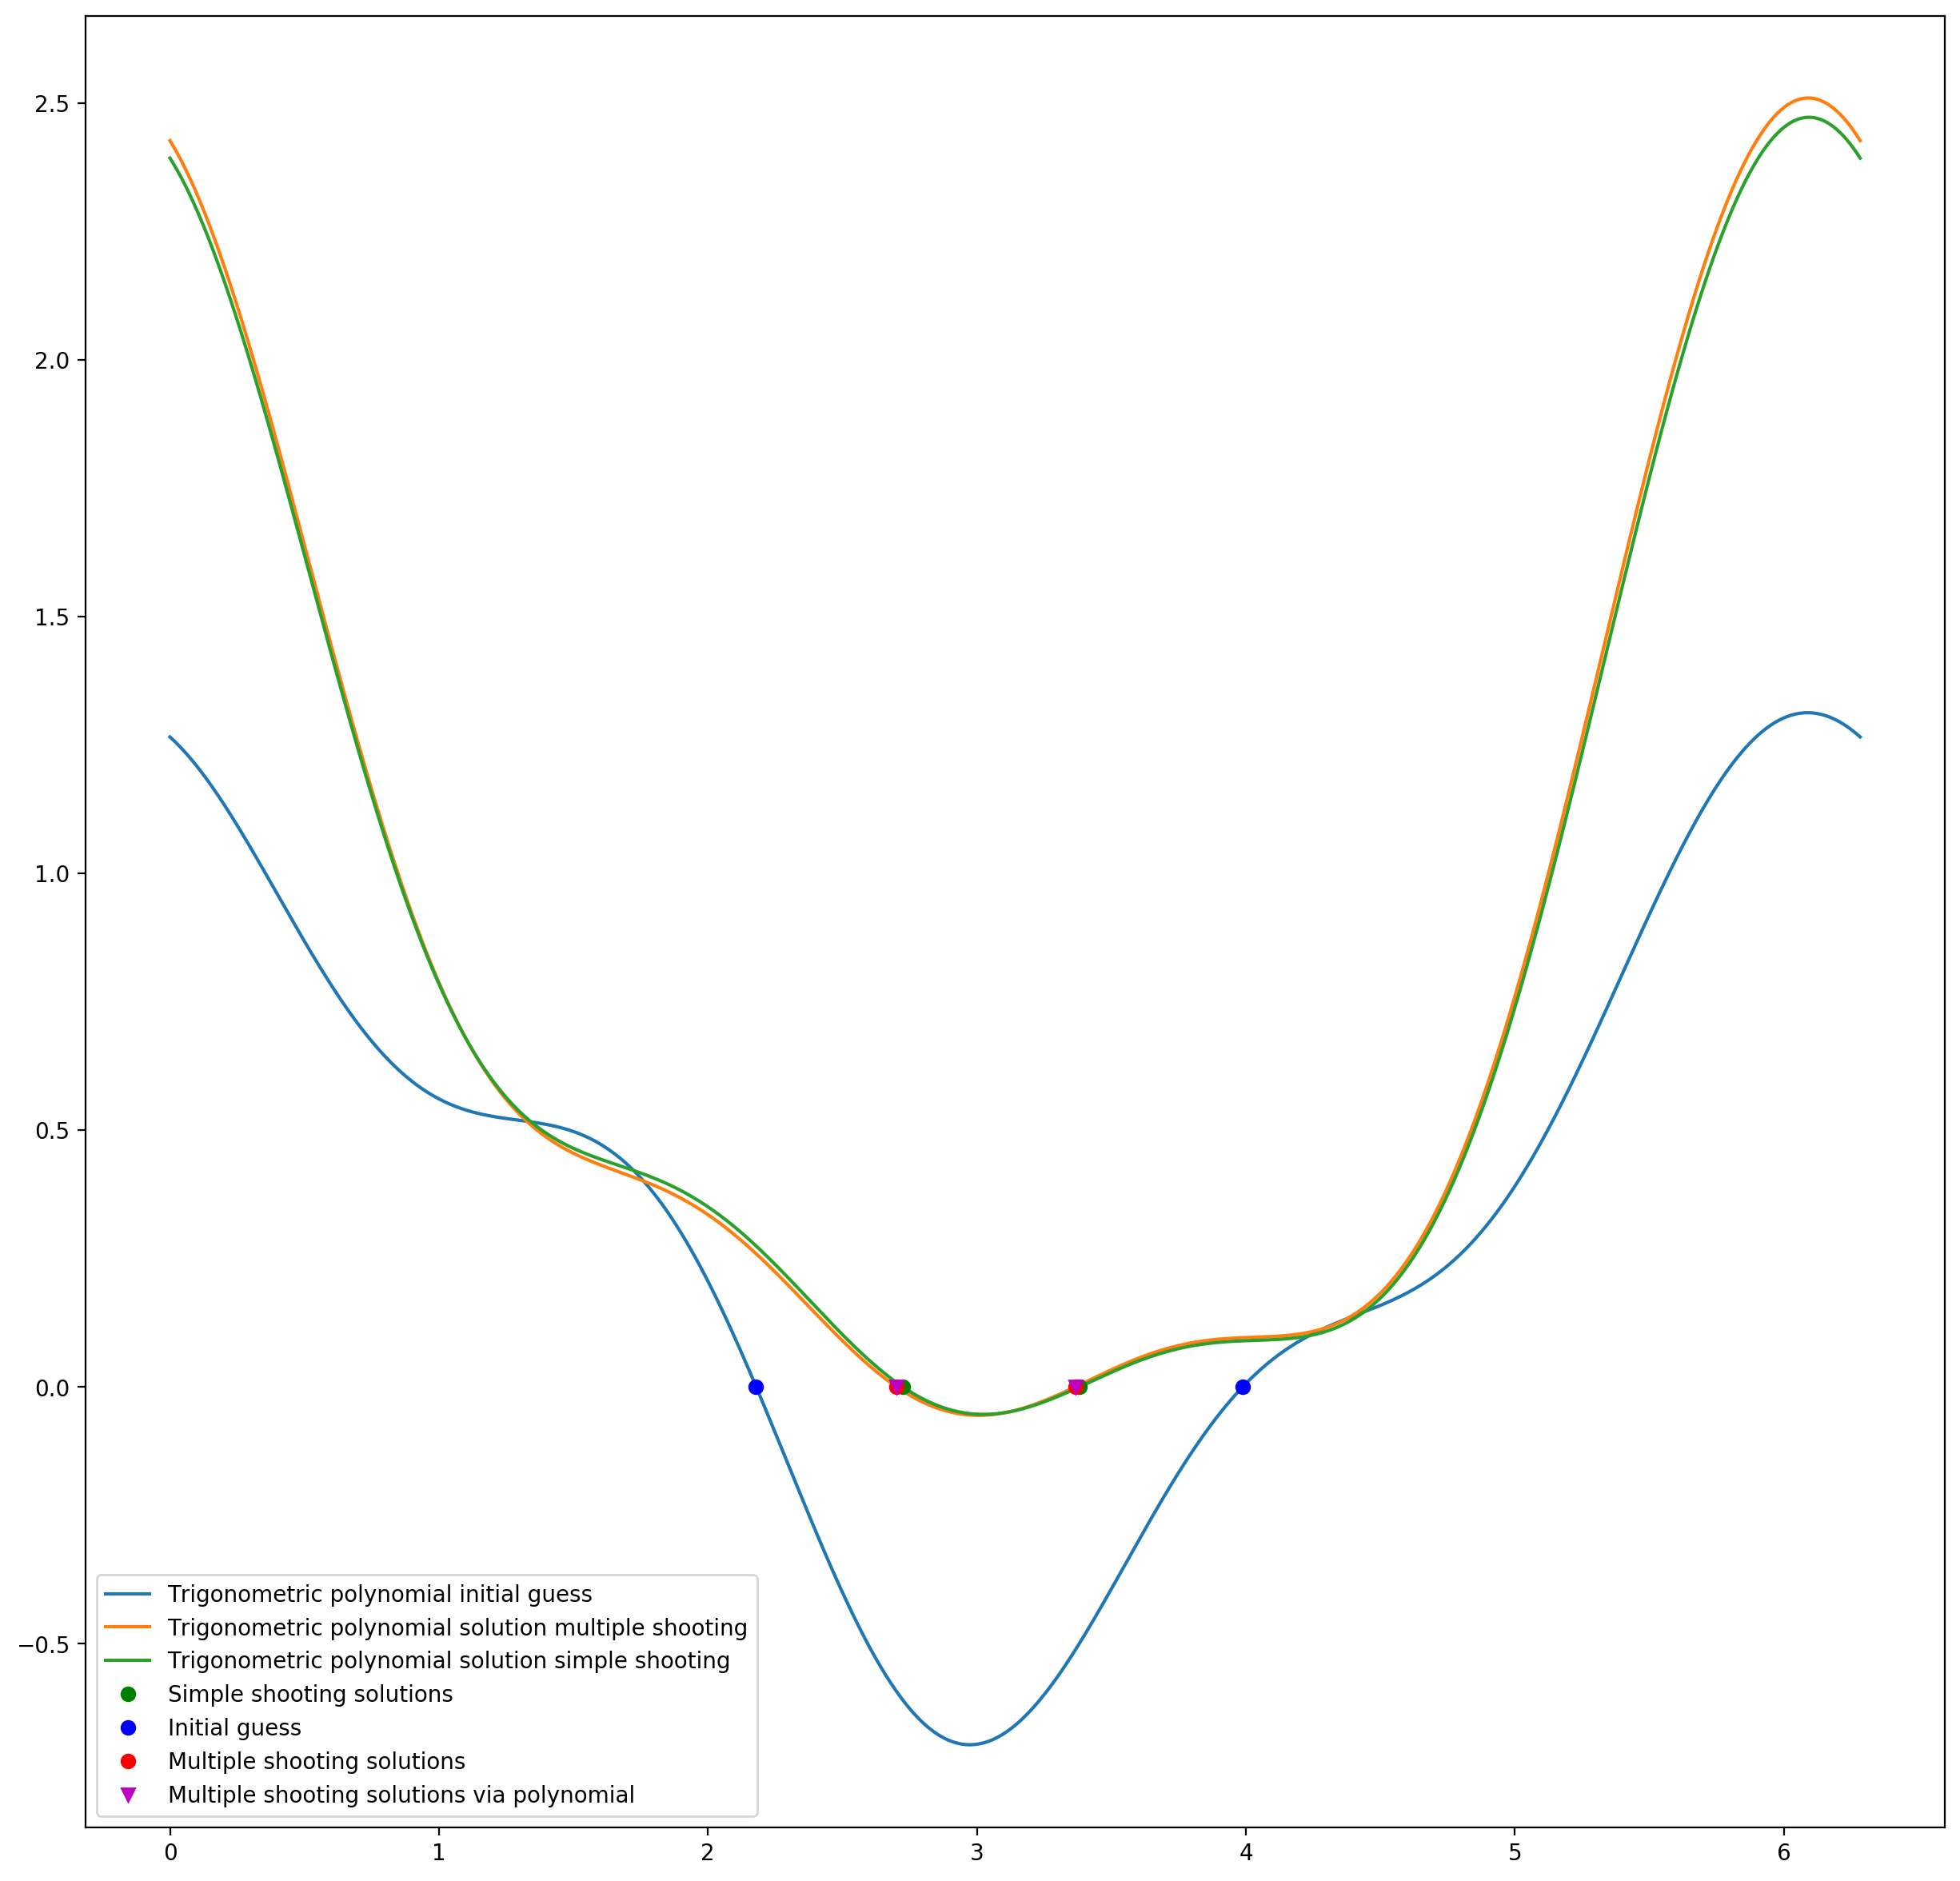

In [173]:
pI_sol              = z_sol[0 : 5]
M1_sol              = z_sol[5]
M2_sol              = z_sol[6]
M_sol               = np.array([M1_sol,M2_sol])
N_fft               = 13 
f_vect              = np.linspace(0, 2 * np.pi, N_fft+1)
y_gve               = find_Fourier_gve(z, pars, N_fft)
y_gve_sol           = find_Fourier_gve(z_sol, pars, N_fft)
y_gve_sol_auto      = find_Fourier_gve(z_sol_auto, pars, N_fft)
sol_angles, sol_all = switch_fun(z_sol_auto, pars)

sol_angles_sol, sol_all_sol = switch_fun(z_sol, pars)


N_grid = 1000
grid = np.linspace(0,2*np.pi,N_grid)
plt.plot(grid, pol_Fourier(y_gve,grid,N_fft), label='Trigonometric polynomial initial guess'); 
plt.plot(grid, pol_Fourier(y_gve_sol,grid,N_fft), label='Trigonometric polynomial solution multiple shooting'); 
plt.plot(grid, pol_Fourier(y_gve_sol_auto,grid,N_fft), label='Trigonometric polynomial solution simple shooting'); 
plt.plot(sol_angles, np.zeros(np.size(sol_angles)), 'go', label='Simple shooting solutions')
f_guess = kepler(I[4], M_guess)
plt.plot(f_guess, np.zeros(np.size(f_guess)), 'bo', label='Initial guess')
f_sol = kepler(I[4], M_sol)
plt.plot(f_sol, np.zeros(np.size(f_sol)), 'ro', label='Multiple shooting solutions')
plt.plot(sol_angles_sol, np.zeros(np.size(sol_angles_sol)), 'mv', label='Multiple shooting solutions via polynomial')
plt.legend()

## Function of plotting continuous integration

In [26]:

@tools.vectorize(vvars =(1,))
def control(M, I, pI, pars, cont):
    sol  = np.array([0., 0., 0.])
    if type(M)==float or type(M)==int:
        if Hu(M, I, pI, pars, cont) < 0.:
            sol = np.array([0., 0., 0.])
        else: 
            sol = ufun(M, I, pI, cont)
    else:
        for ii in range(len(M)):
            if Hu(M[ii], I, pI, pars, cont) < 0.:
                sol = np.vstack((sol, np.array([0., 0., 0.])))
            else: 
                sol = np.vstack((sol, ufun(M[ii], I, pI, cont)))   
        sol = np.delete(sol, 0, 0)
    return sol


def plotSolutionBSB(pI, M1, M2, Mf, sDir, cont, nOrb):

    N       = 500
    
    M_vect  = np.array([])
    g1      = np.array([])
    g2      = np.array([])
    g3      = np.array([])
    a       = np.array([])
    e       = np.array([])
    I       = np.array([0., 0., 0., 0., 0]) 
    I0      = np.array([0., 0., 0., 0., 0]) 
    M0      = 0
    M0_2_M1 = np.linspace(M0, M1, N+1)
    M1_2_M2 = np.linspace(M1, M2, N+1)
    M2_2_Mf = np.linspace(M2, Mf, N+1)
    u_vect  = np.array([0., 0., 0.])
        
    for ii in range(nOrb):
        Mspan1  = list((ii)*2*np.pi*np.ones(N+1)+M0_2_M1)
        Mspan2  = list((ii)*2*np.pi*np.ones(N+1)+M1_2_M2)
        Mspanf  = list((ii)*2*np.pi*np.ones(N+1)+M2_2_Mf)
        
        I1sol, pI1sol = fu(M0, I0, pI, Mspan1[1:], pars, cont)  # on [ 0, t1]
        #I2sol, pI2sol = f0(Mspan1[-1], I1sol[-1], pI, Mspan2, pars, cont)  # on [t1, t2]
        #Ifsol, pIfsol = fu(Mspan2[-1], I2sol[-1], pI, Mspanf, pars, cont)  # on [t2, tf]
        I2sol, pI2sol = f0(M1, I1sol[-1], pI, Mspan2[1:], pars, cont)  # on [t1, t2]
        Ifsol, pIfsol = fu(M2, I2sol[-1], pI, Mspanf[1:], pars, cont)  # on [t2, tf]
        
        M_vect        = np.hstack((M_vect, Mspan1[1:], Mspan2[1:], Mspanf[1:]))  
        
        print(np.shape(M_vect))
        #for kk in range(N+1):
        for kk in range(N):
            val           = I1sol[kk]
            g1            = np.hstack((g1, val[0]))
            g2            = np.hstack((g2, val[1]))
            g3            = np.hstack((g3, val[2]))
            a             = np.hstack((a, val[3]))
            e             = np.hstack((e, val[4]))
            
        for kk in range(N):
            val           = I2sol[kk]
            g1            = np.hstack((g1, val[0]))
            g2            = np.hstack((g2, val[1]))
            g3            = np.hstack((g3, val[2]))
            a             = np.hstack((a, val[3]))
            e             = np.hstack((e, val[4]))
            
        for kk in range(N):
            val           = Ifsol[kk]
            g1            = np.hstack((g1, val[0]))
            g2            = np.hstack((g2, val[1]))
            g3            = np.hstack((g3, val[2]))
            a             = np.hstack((a, val[3]))
            e             = np.hstack((e, val[4]))
            
        #I0            = Ifsol[-1]
        #M0            = Mspanf[-1]
    
    u_vect = control(M_vect, I, pI, pars, cont)
    u_s    = np.dot(u_vect,sDir)
    u_1    = u_vect[:,0]
    u_2    = u_vect[:,1]
    u_3    = u_vect[:,2]

    #ang1   = np.arccos(u_s/np.linalg.norm(u_vect,axis=1))
    #where_are_NaNs = np.isnan(ang1)
    #ang1[where_are_NaNs] = 0
    #ang1   = rad2deg(ang1)
    
    #ang2   = np.sqrt(np.divide(u_3 ** 2, u_2 ** 2))
    #where_are_NaNs = np.isnan(ang2)
    #ang2[where_are_NaNs] = 0
    # FALSE
    #ang2   = np.arctan2(u_3 ** 2, u_2 ** 2)
    #ang2   = rad2deg(ang2)
    
    #### write a file to plot it using matlab
    #file1 = open("results/Results_angles.txt","w+")
    file2 = open("results/Results_projections.txt","w+")

    #array_ang = np.transpose(np.array([M_vect, ang1, ang2]))
    array_proj = np.transpose(np.array([M_vect,u_1,u_2,u_3]))
    #print(array_proj)
    #np.savetxt(file1, array_ang , delimiter=",")
    np.savetxt(file2, array_proj , delimiter=",")

    #file1.close()
    file2.close()


    

    #M_vect = M_vect/(2*np.pi)
    M_vect = M_vect / 2 / np.pi * 360
    fig = plt.figure(); plt.tight_layout()
    ax1  = fig.add_subplot(421); 
    ax1.plot(M_vect, g1); 
    ax2  = fig.add_subplot(422); 
    ax2.plot(M_vect, g2); 
    ax3  = fig.add_subplot(423); 
    ax3.plot(M_vect, g3); 
    ax4  = fig.add_subplot(424); 
    ax4.plot(M_vect, a); 
    ax5  = fig.add_subplot(425); 
    ax5.plot(M_vect, e); 
    #ax6  = fig.add_subplot(426); 
    #ax6.plot(M_vect, u_s); 
    ax6  = fig.add_subplot(426); 
    #ax6.plot(M_vect, ang1, label='cone angle'); 
    #ax6.plot(M_vect, ang2, label='clock angle'); 
    #ax7  = fig.add_subplot(428); 
    ax6.plot(M_vect, -u_3, label='$u_1$'); 
    ax6.plot(M_vect, u_1, label='$u_2$');
    ax6.plot(M_vect, -u_2, label='$u_3$');
    
    label_name = 'Satellite longitude [deg]'
    #label_name = '$Orbit \, number$'
    
    ax1.set_xlabel(label_name); ax1.set_ylabel('$\gamma_1 \epsilon^{-1}$'); ax1.axhline(0, color='k')
    ax2.set_xlabel(label_name); ax2.set_ylabel('$\gamma_2 \epsilon^{-1}$'); ax2.axhline(0, color='k')
    ax3.set_xlabel(label_name); ax3.set_ylabel('$\gamma_3 \epsilon^{-1}$'); ax3.axhline(0, color='k')
    ax4.set_xlabel(label_name); ax4.set_ylabel('$a \epsilon^{-1}$');        ax4.axhline(0, color='k')
    ax5.set_xlabel(label_name); ax5.set_ylabel('$e \epsilon^{-1}$');        ax5.axhline(0, color='k')
    ax6.set_xlabel(label_name); ax6.set_ylabel('$Control \ angle $');      #ax7.axhline(0, color='k')
    #ax6.set_xlabel(label_name); ax7.set_ylabel('$u$');      #ax6.axhline(0, color='k')
    #ax8.set_xlabel(label_name); ax8.set_ylabel('$Cone \ ang2$');      ax8.axhline(0, color='k')
    #ax9.set_xlabel(label_name); ax9.set_ylabel('$u_4$');      ax9.axhline(0, color='k')
    ax6.legend()
    #ax7.legend()
    plt.savefig('figures/plot.png')


## Plots

In [27]:
pI         = z_sol[0 : 5]
M1         = z_sol[5]
M2         = z_sol[6]
I1         = z_sol[7 : 12]
I2         = z_sol[12 : 17]

If, pI = fu(M2, I2, pI, 2*np.pi, pars, cont)

(1500,)


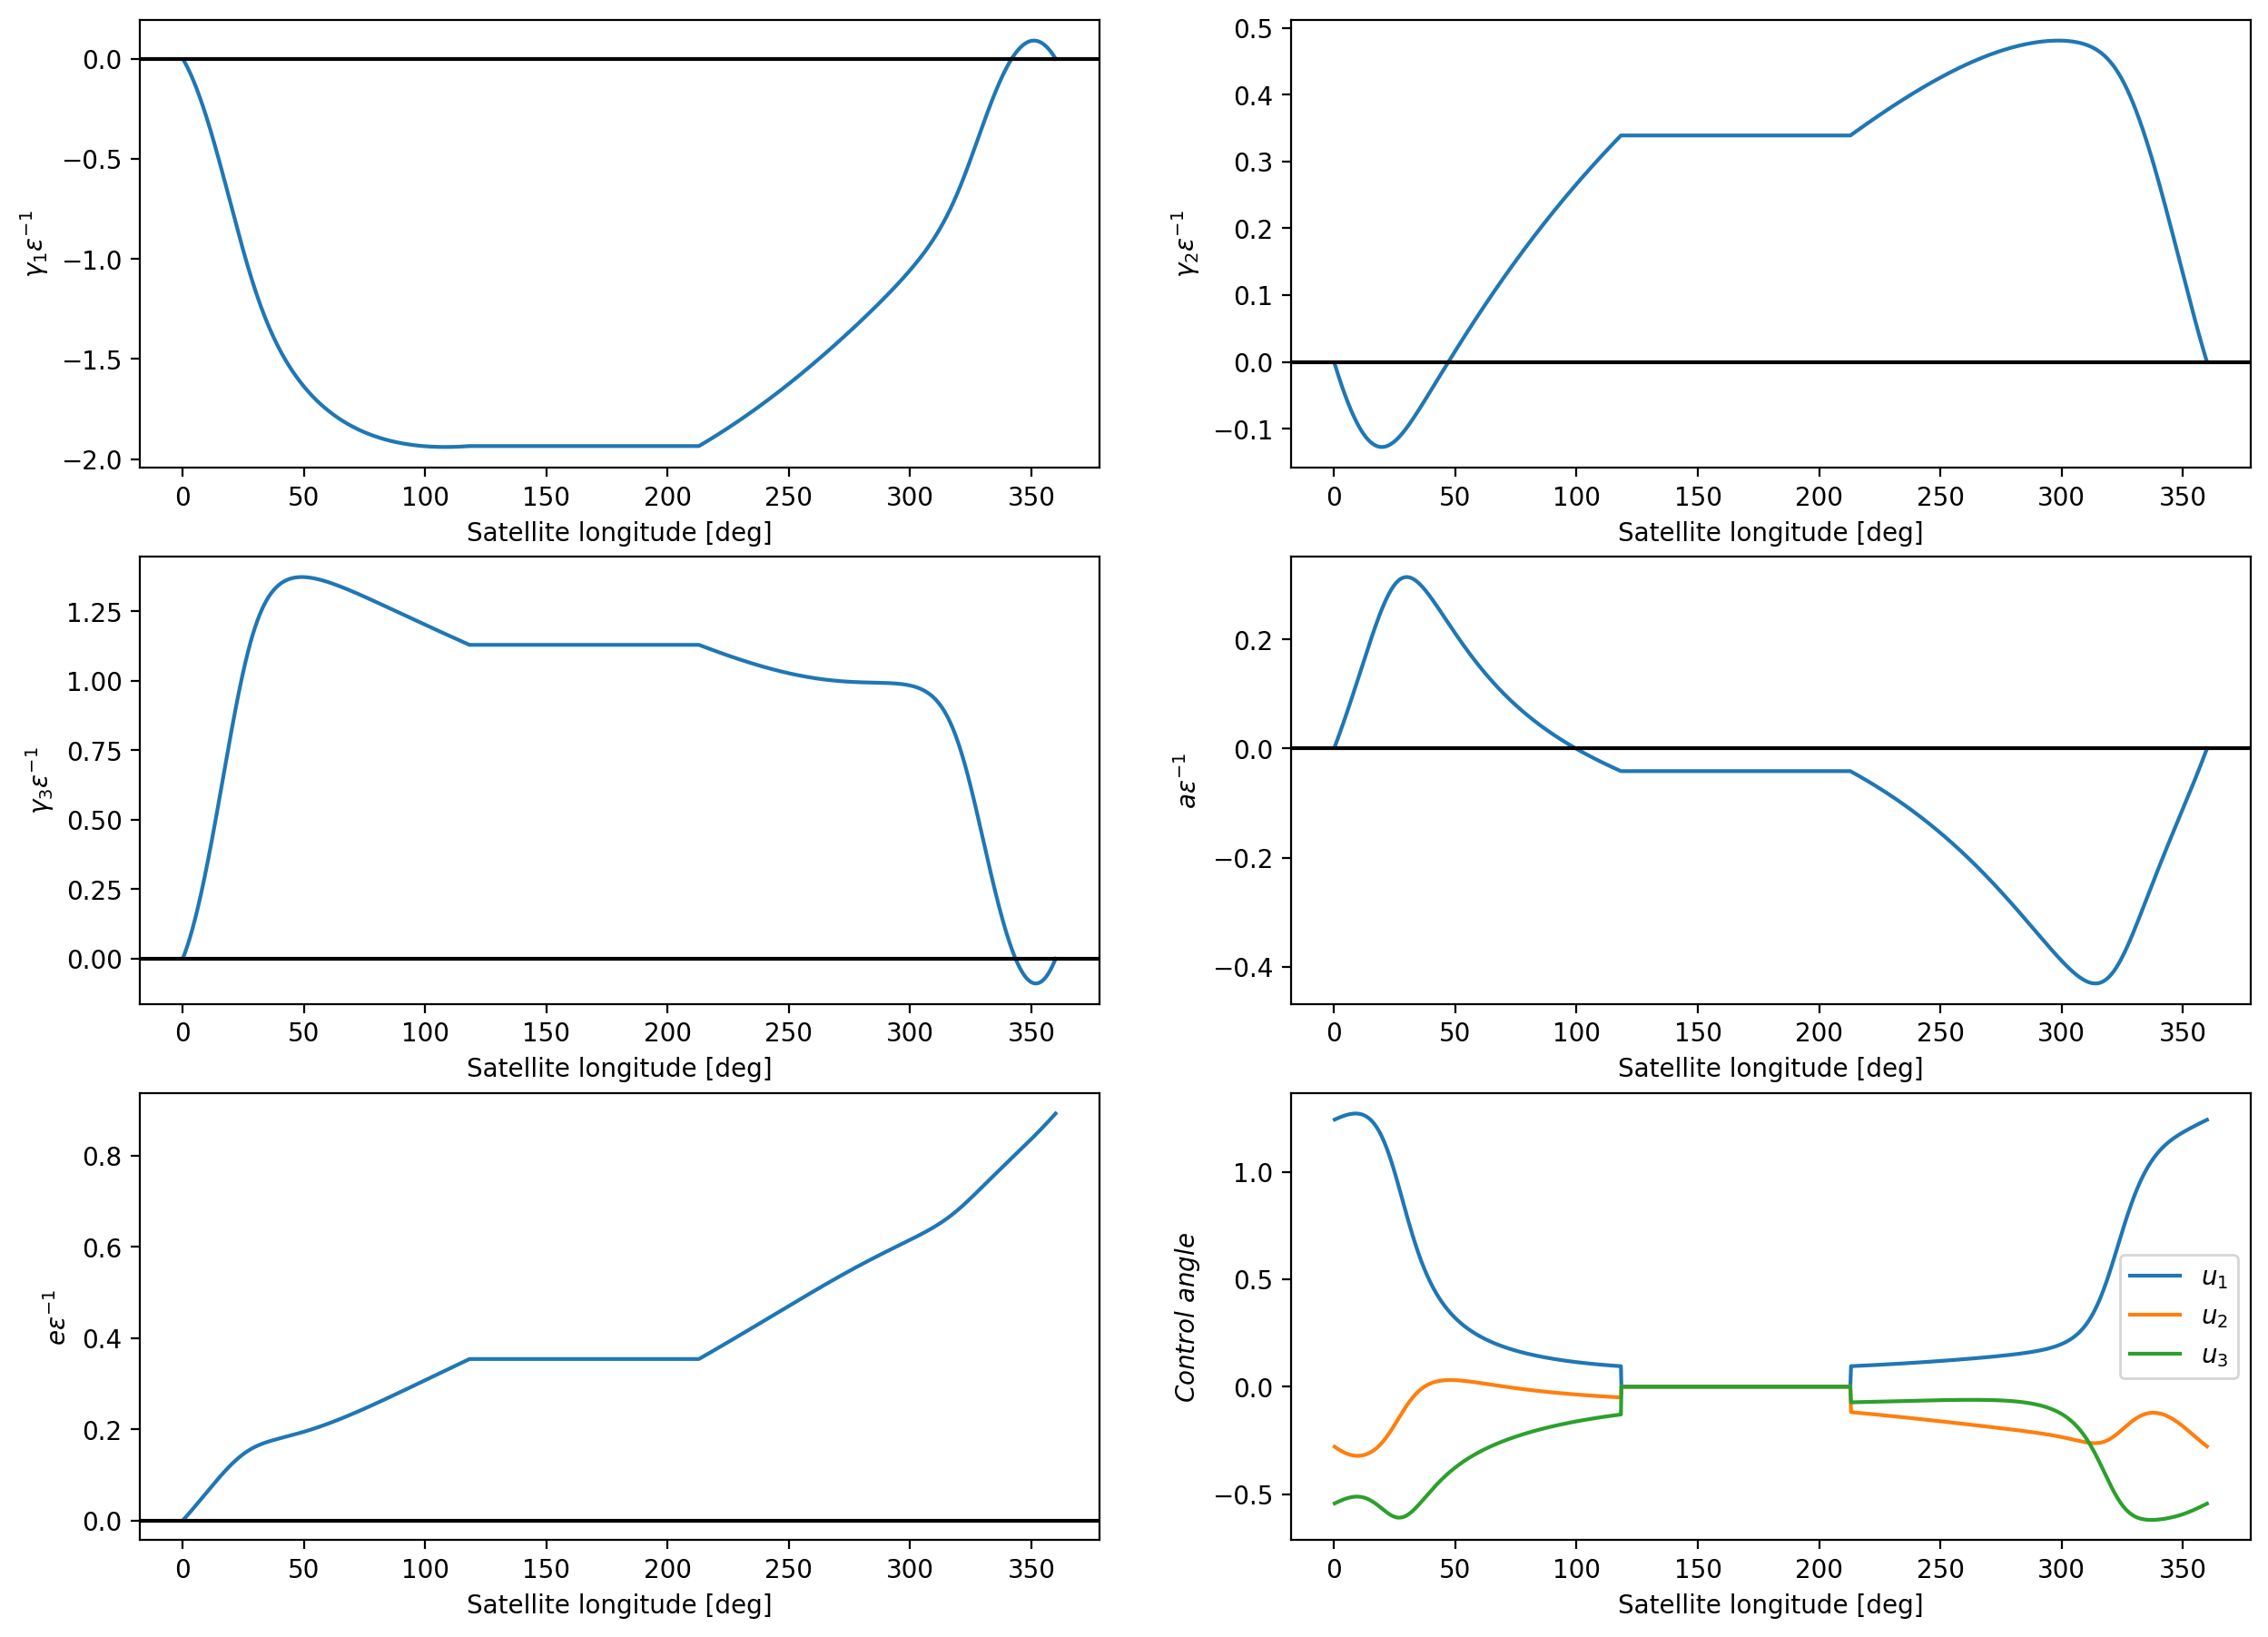

In [28]:
NumOrbits   = 1 
plotSolutionBSB(pI, M1, M2, Mf, sDir, cont, NumOrbits)


## Function of continuous integration

In [29]:
# Definition of the homotopic function and its first order derivative
# This function is used to solve S=0 for different values of e=epsilon and tf.
def dhomfun(z, dz, lam, dlam):
    s, ds_z = foo((z, dz), lam)
    
    dx     = 1.0e-8
    ds_lam = (foo(z, lam - dx) - foo(z, lam + dx)) / dx / 2 * dlam
    
    ds      = ds_z + ds_lam
    return s, ds

@tools.tensorize(dhomfun, tvars=(1, 2), full=True)
def homfun(z, lam):
    s = foo(z, lam)
    return s

homfun((z_sol, np.zeros(17)), (cont, 1.))

(array([ 0.00000000e+00,  3.38921119e-01,  1.12967210e+00, -4.14397284e-02,
         1.93479069e+00,  1.01131326e-11,  0.00000000e+00, -1.93479069e+00,
         3.38921119e-01,  1.12967210e+00, -4.14397284e-02,  3.54166559e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00]),
 array([ 0.00000000e+00,  3.95693301e-01,  7.85592698e-01, -1.21934888e-01,
         1.06424079e+00,  2.77880987e-17,  0.00000000e+00, -1.56727569e+00,
         1.14065860e-01,  1.19631260e+00,  2.81628523e-02,  1.61084779e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00]))

## Homotopic function

In [1]:

# Making the penalization smaller: homotopy on e
z0         = z_sol
#sol_path   = path.solve(homfun, z0, 0., 1., df=homfun)
sol_path   = path.solve(homfun, z0, 0., 1.)


NameError: name 'z_sol' is not defined

In [25]:

print(sol_path)


'\nprint(sol_path)\n'

## POST PROCESSING SHOOT 

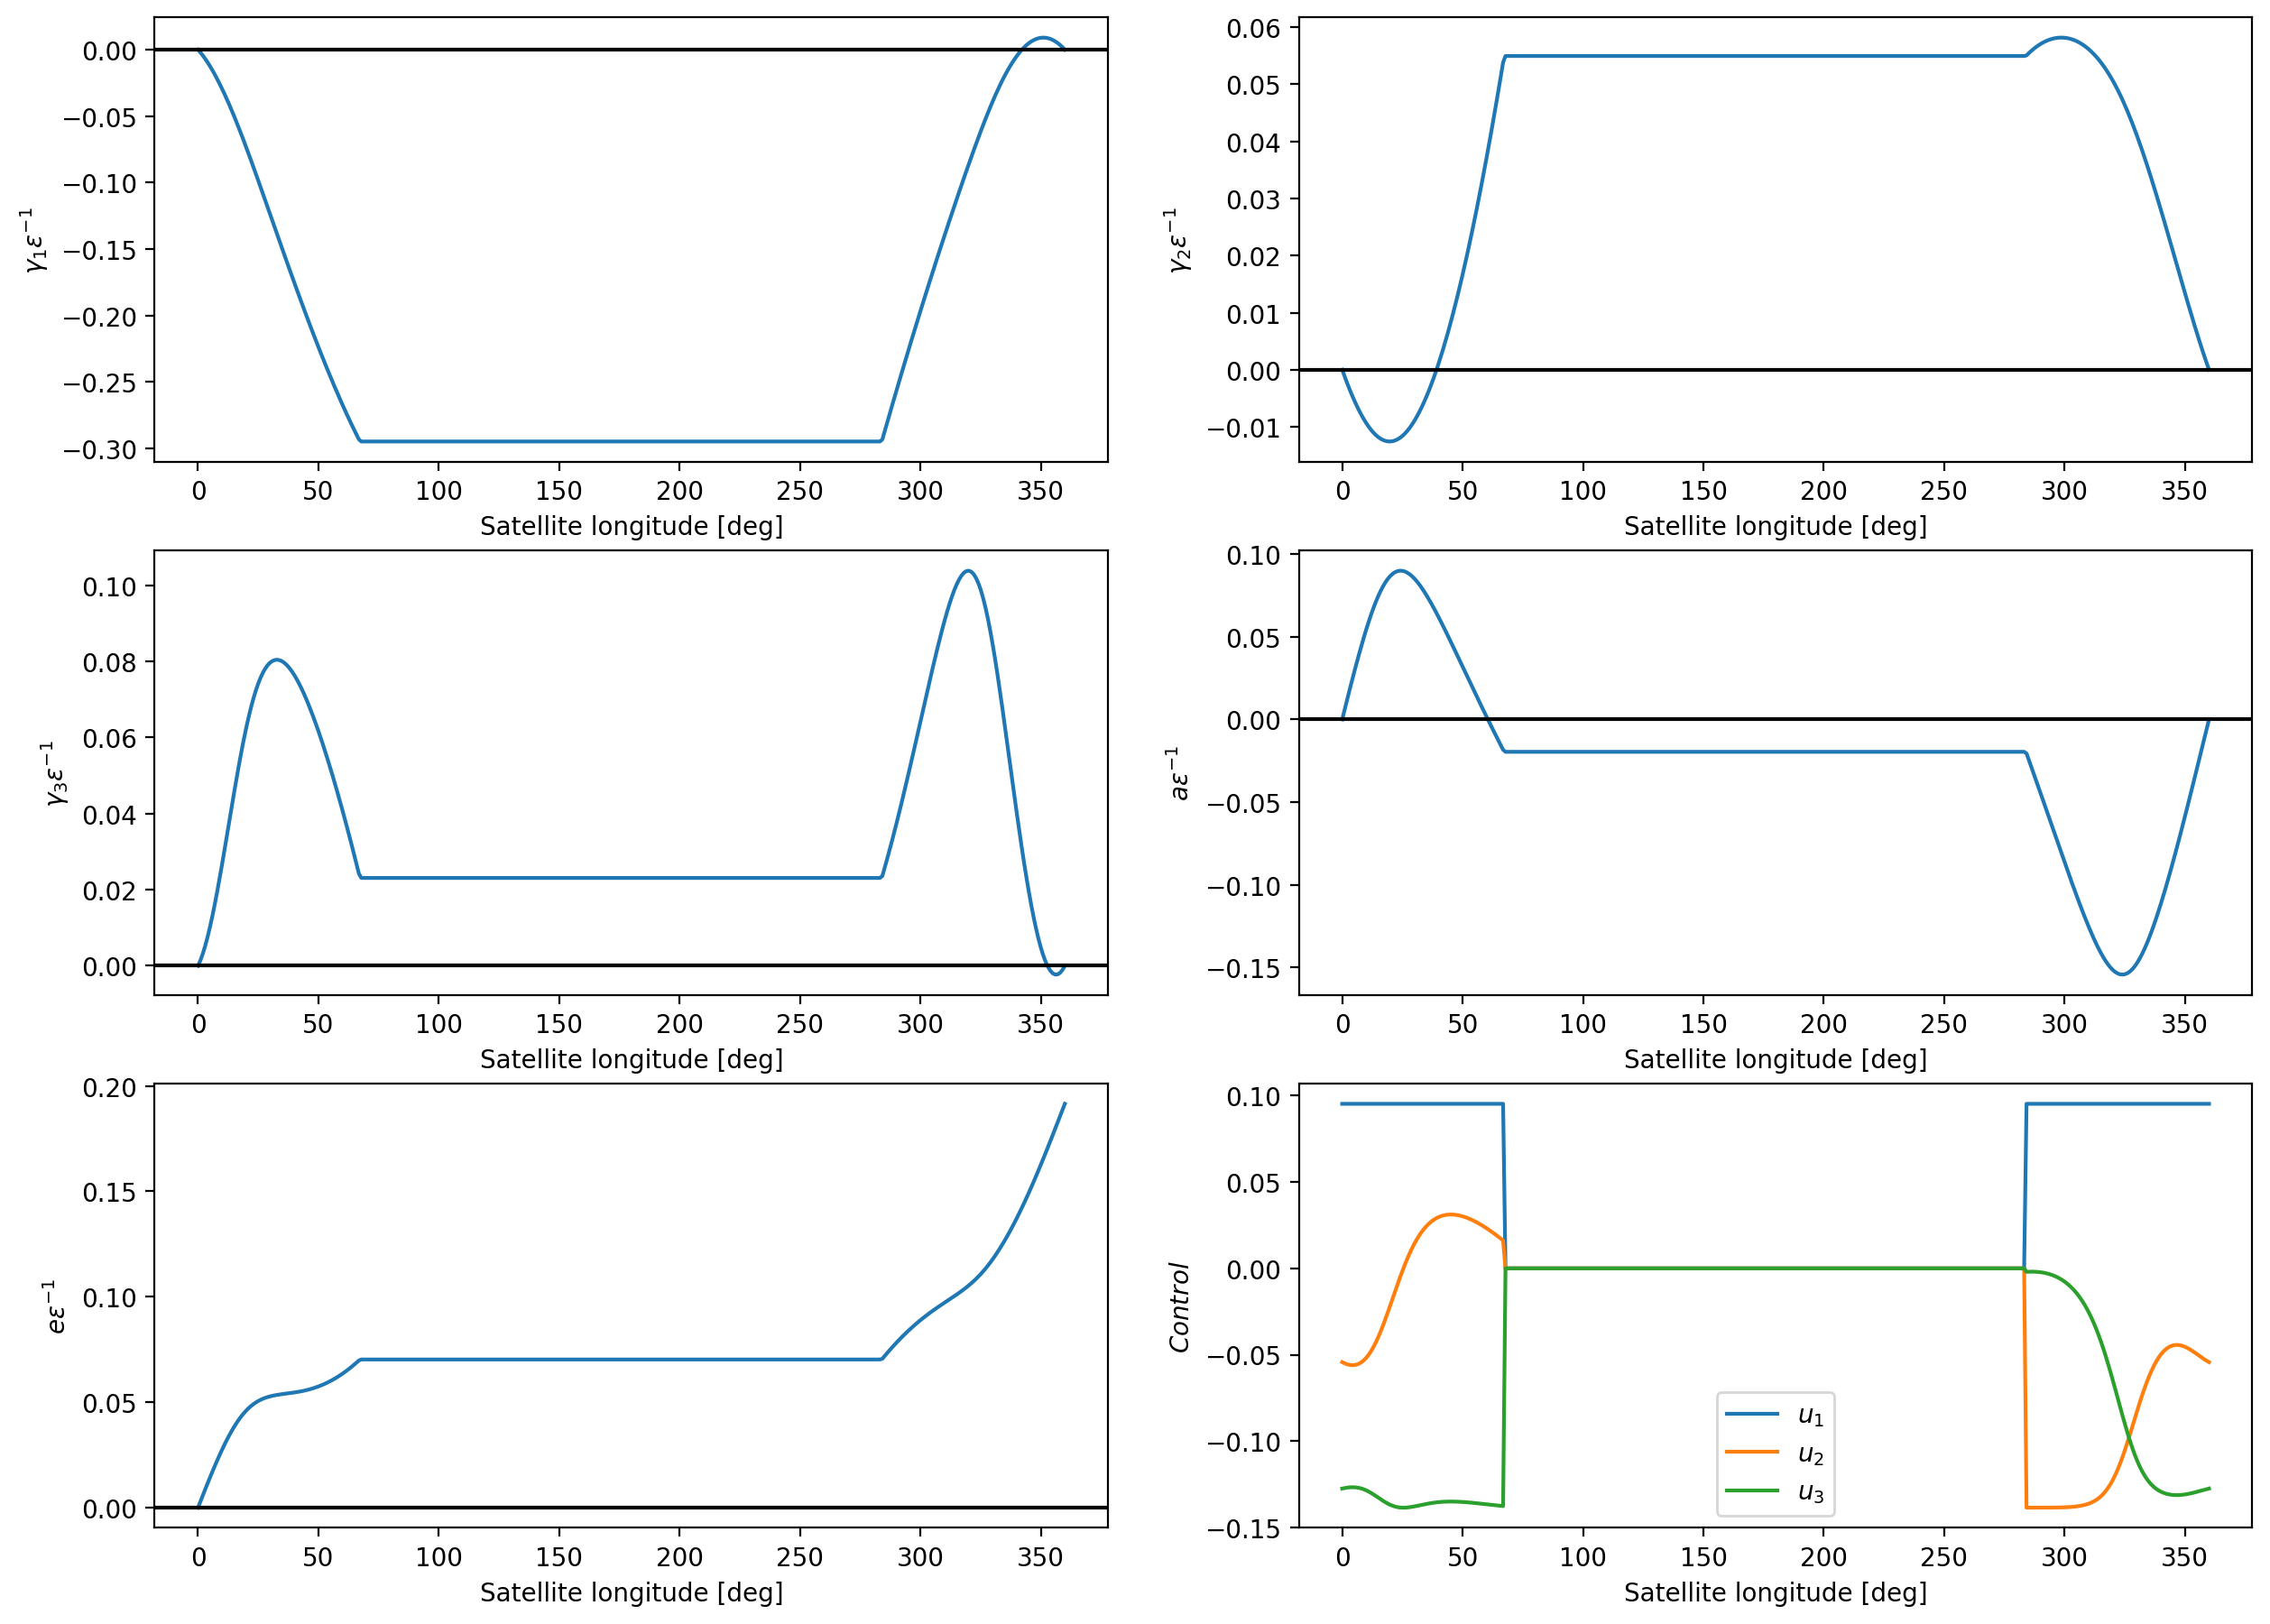

In [12]:
# Inputs
Ndis         = 360 + 1
#dpI0         = z_sol_auto[0 : 5]
dpI0         = z_sol[0 : 5]

# Integration of the trajectory
M            = list(np.linspace(0., 2. * np.pi, Ndis + 1))
dI0          = np.zeros(5)

dI, dpI      = fu(0., dI0, dpI0, M, pars, cont)

g1           = np.zeros(Ndis + 1)
g2           = np.zeros(Ndis + 1)
g3           = np.zeros(Ndis + 1)
a            = np.zeros(Ndis + 1)
e            = np.zeros(Ndis + 1)
u            = np.zeros((Ndis + 1, 3))

for kk in range(Ndis + 1):
    g1[kk]   = dI[kk][0]
    g2[kk]   = dI[kk][1]
    g3[kk]   = dI[kk][2]
    a[kk]    = dI[kk][3]
    e[kk]    = dI[kk][4]
    u[kk]    = control(M[kk], dI[kk], dpI[kk], pars, cont)

# Components of the control vector
u_s          = np.dot(u,sDir)
u_1          = u[:,0]
u_2          = u[:,1]
u_3          = u[:,2]

np.seterr(divide='ignore', invalid='ignore')
uCone        = np.arccos(u_s / np.linalg.norm(u, axis = 1))
coast        = np.isnan(uCone)
uCone[coast] = 0.
uClock       = np.arctan2(u[:, 1], u[:, 0])


#file1 = open("results/Results_mult_shoot.txt","w+")
file1 = open("results/Results_mult_shoot_cont0.txt","w+")
#file1 = open("results/Results_simple_shoot_change_structure.txt","w+")
array_proj = np.transpose(np.array([M,u_1,u_2,u_3]))
np.savetxt(file1, array_proj , delimiter=",")
file1.close()

#file2 = open("results/Traj_mult_shoot.txt","w+")
file2 = open("results/Traj_mult_shoot_cont0.txt","w+")
#file2 = open("results/Traj_simple_shoot_change_structure.txt","w+")
array_traj = np.transpose(np.array([M,g1,g2,g3,a,e]))
np.savetxt(file2, array_traj , delimiter=",")
file2.close()

    
# Plot
Mdeg         = [Mi * 180. / np.pi for Mi in M] 

fig          = plt.figure(); plt.tight_layout()
ax1          = fig.add_subplot(421) 
ax2          = fig.add_subplot(422) 
ax3          = fig.add_subplot(423) 
ax4          = fig.add_subplot(424) 
ax5          = fig.add_subplot(425) 
ax6          = fig.add_subplot(426) 

ax1.plot(Mdeg, g1)
ax2.plot(Mdeg, g2) 
ax3.plot(Mdeg, g3) 
ax4.plot(Mdeg, a) 
ax5.plot(Mdeg, e)
#ax6.plot(Mdeg, uCone * 180. / np.pi, label='cone angle')
#ax6.plot(Mdeg, uClock * 180. / np.pi, label='clock angle') 

ax6.plot(Mdeg, -u_3, label='$u_1$'); 
ax6.plot(Mdeg, u_1, label='$u_2$');
ax6.plot(Mdeg, -u_2, label='$u_3$');

xlabel       = 'Satellite longitude [deg]'
ax1.set_xlabel(xlabel); ax1.set_ylabel('$\gamma_1 \epsilon^{-1}$'); ax1.axhline(0, color='k')
ax2.set_xlabel(xlabel); ax2.set_ylabel('$\gamma_2 \epsilon^{-1}$'); ax2.axhline(0, color='k')
ax3.set_xlabel(xlabel); ax3.set_ylabel('$\gamma_3 \epsilon^{-1}$'); ax3.axhline(0, color='k')
ax4.set_xlabel(xlabel); ax4.set_ylabel('$a \epsilon^{-1}$');        ax4.axhline(0, color='k')
ax5.set_xlabel(xlabel); ax5.set_ylabel('$e \epsilon^{-1}$');        ax5.axhline(0, color='k')
#ax6.set_xlabel(xlabel); ax6.set_ylabel('$Control \ angle $'); 
ax6.set_xlabel(xlabel); ax6.set_ylabel('$Control$'); 
ax6.legend()
plt.savefig('figures/plot.png')



In [88]:
print(z_sol[0 : 5])

[-0.24329854 -0.84432233 -0.09685917 -0.23875016  1.        ]


# Integration of trajectory by injecting the control

In [20]:
def dynamics(t, x, z_sol, pars, cont):
    Csrp       = 1e-8
    dpI0       = z_sol[0 : 5]
    dI0        = np.zeros(5)
    dI, dpI    = fu(0., dI0, dpI0, x[5], pars, cont)
    u          = Csrp * control(x[5], dI, dpI, pars, cont)
    mu         = pars[0]	
    [Fx,Fy,Fz] = gveeci(x, mu)
    dx         = np.dot(np.transpose(np.array([Fx,Fy,Fz])), u)
    n          = np.sqrt(mu/(x[3]**3))
    dx[-1]     = dx[-1] + n
    return dx
    



dyn_fun       = lambda t, x        : dynamics(t, x, z_sol, pars, cont)



"""    
x0, t0 = np.hstack((I,0)), 0
r      = ode(dynamics)
r.set_initial_value(x0, t0).set_f_params(z_sol, pars, cont)
tf     = 2*np.pi
Nsteps = 360
dt     = (tf-t0)/Nsteps
out    = np.zeros([Nsteps, 6])
time   = np.zeros(Nsteps+1)
for ii in range(Nsteps):
    time[ii+1] = time[ii] + dt
    out[ii,:]  = r.integrate(r.t + dt)   
"""   
    

'    \nx0, t0 = np.hstack((I,0)), 0\nr      = ode(dynamics)\nr.set_initial_value(x0, t0).set_f_params(z_sol, pars, cont)\ntf     = 2*np.pi\nNsteps = 360\ndt     = (tf-t0)/Nsteps\nout    = np.zeros([Nsteps, 6])\ntime   = np.zeros(Nsteps+1)\nfor ii in range(Nsteps):\n    time[ii+1] = time[ii] + dt\n    out[ii,:]  = r.integrate(r.t + dt)   \n'

In [21]:
x0, t0 = np.hstack((I,0)), 0
Nsteps = 360
tf     = 2*np.pi
sol    = scipy.integrate.RK45(dyn_fun, t0, x0, t_bound = tf, max_step = tf/Nsteps, rtol=0.001, atol=1e-06)

t_values = []
g1_values = []
g2_values = []
g3_values = []
a_values = []
e_values = []
for i in range(500):
    # get solution step state
    sol.step()
    t_values.append(sol.t)
    g1_values.append(sol.y[0])
    g2_values.append(sol.y[1])
    g3_values.append(sol.y[2])
    a_values.append(sol.y[3])
    e_values.append(sol.y[4])
    # break loop after modeling is finished
    if sol.status == 'finished':
        break
  

In [22]:
file2 = open("results/Traj_real_multiple_shoot.txt","w+")
array_traj = np.transpose(np.array([t_values,g1_values,g2_values,g3_values,a_values,e_values]))
np.savetxt(file2, array_traj , delimiter=",")
file2.close()



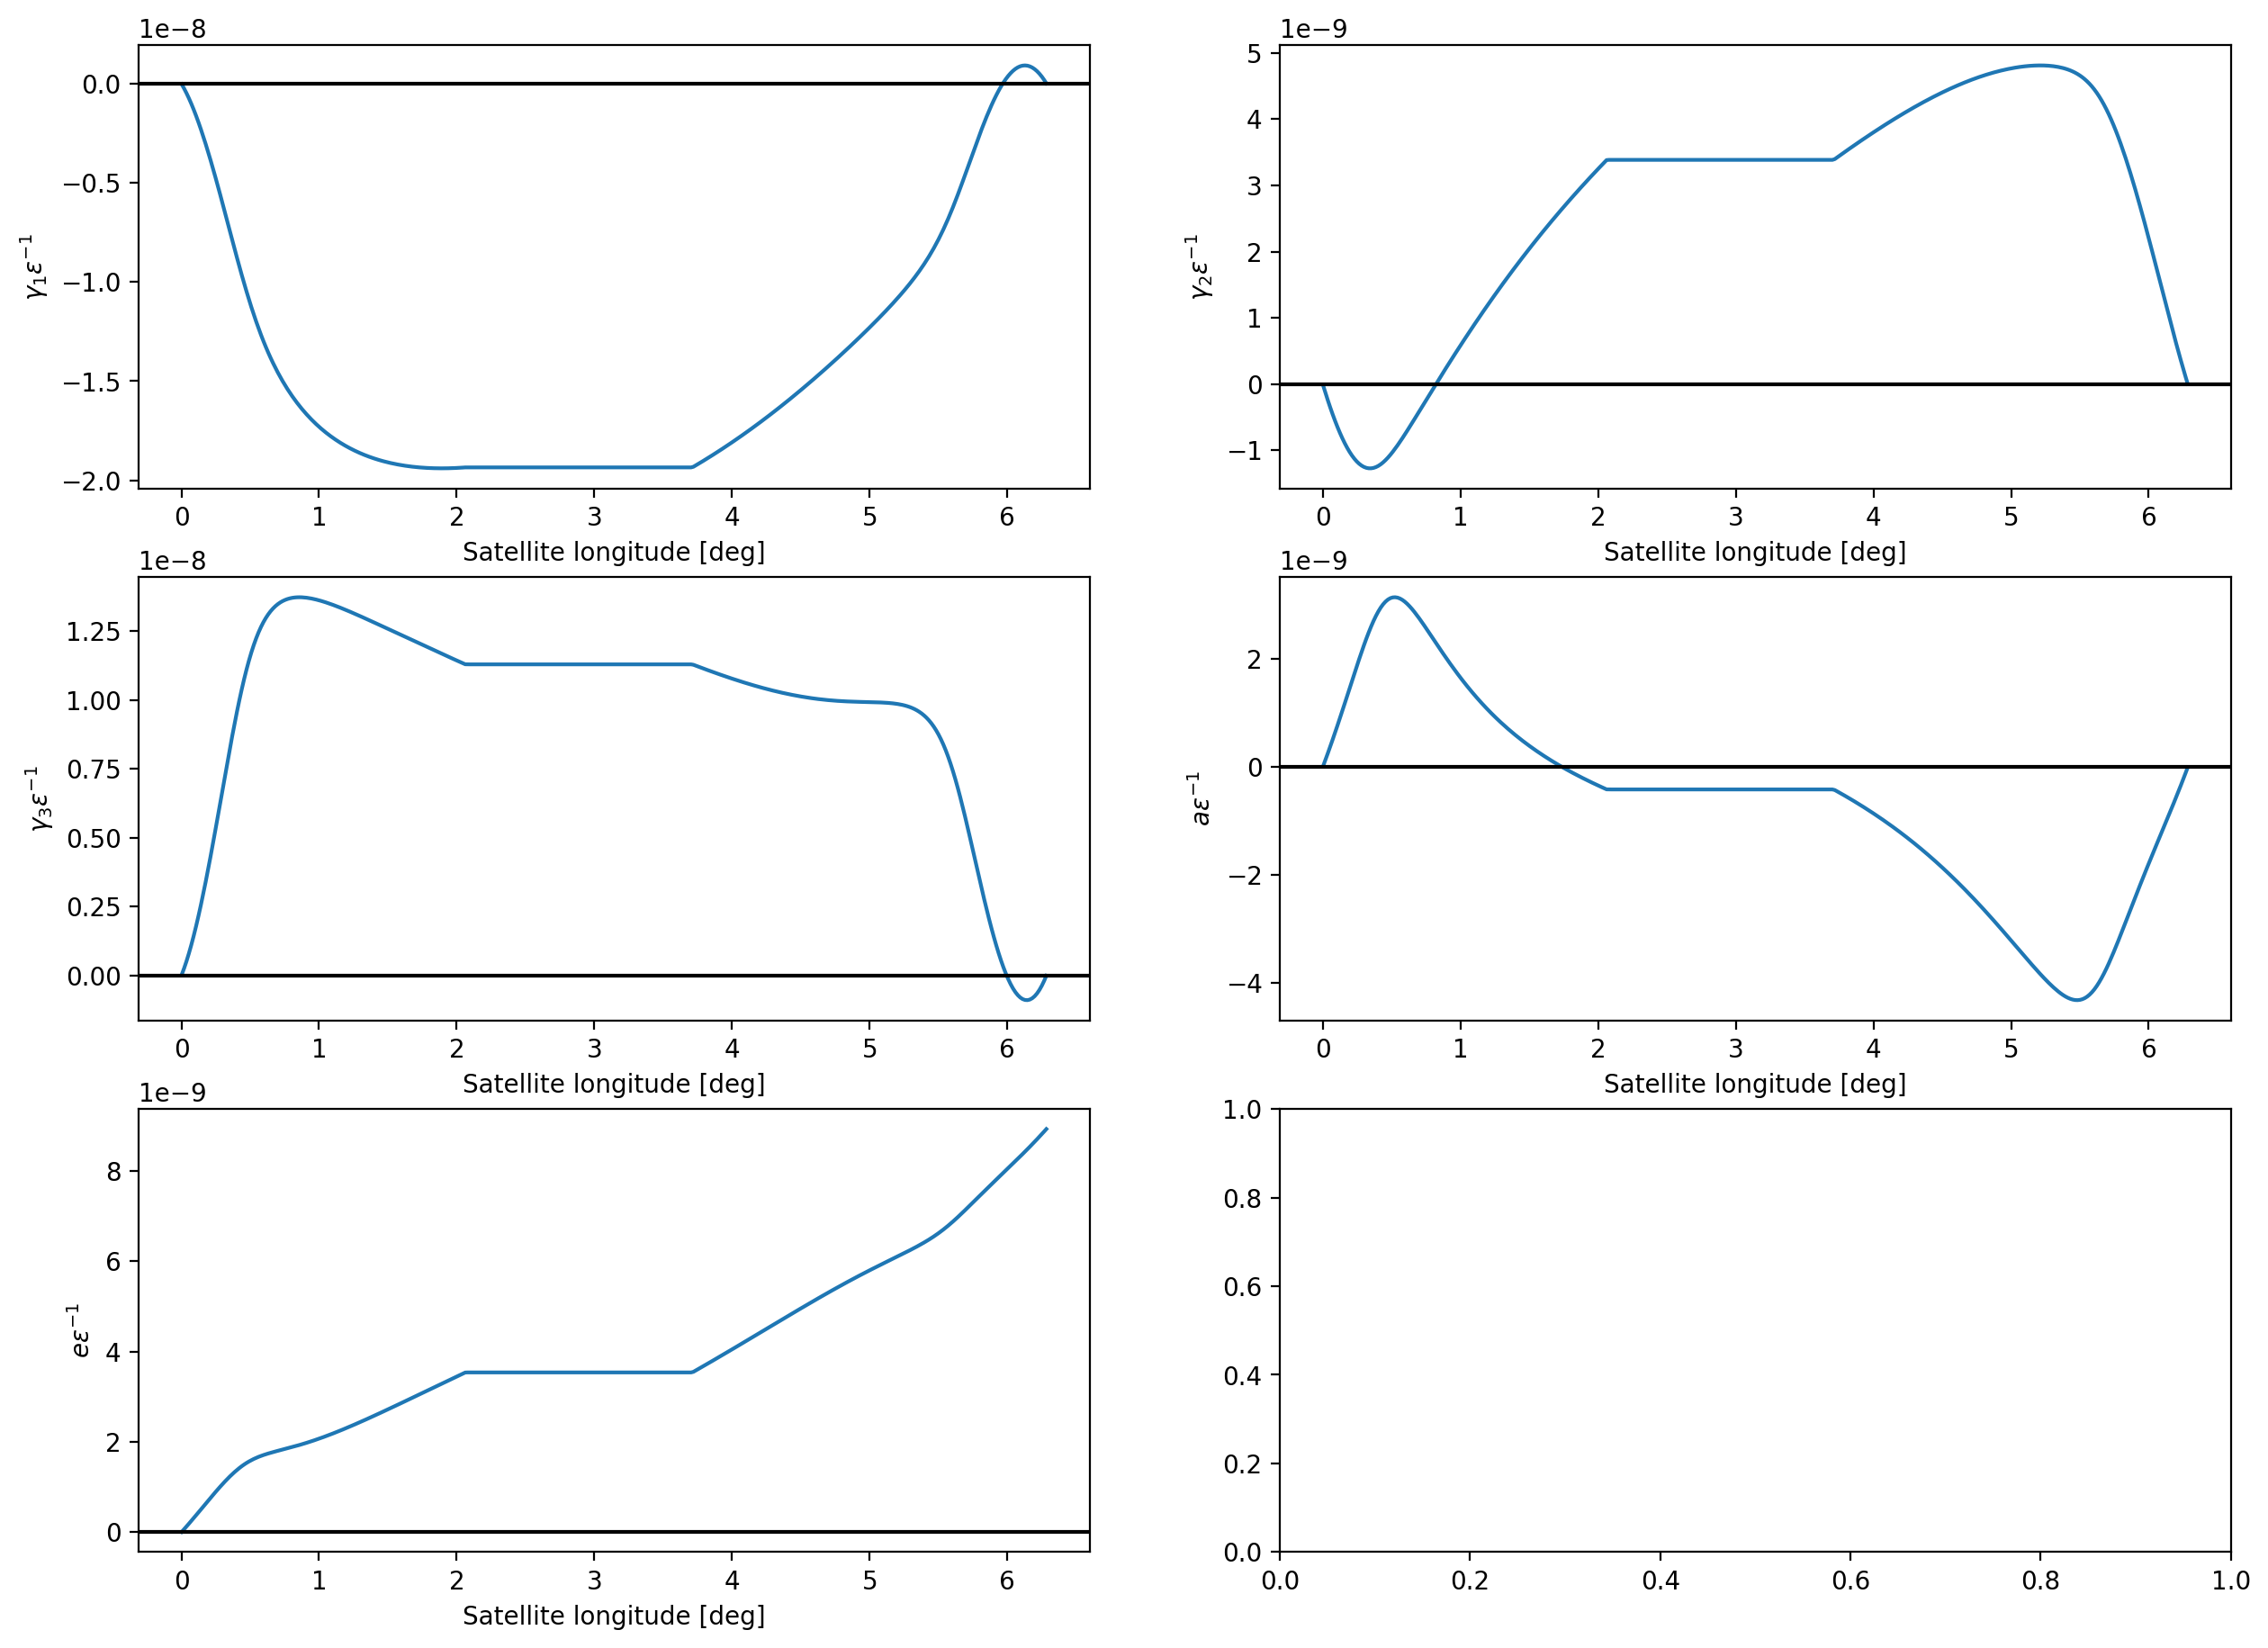

In [23]:
fig          = plt.figure(); plt.tight_layout()
ax1          = fig.add_subplot(421) 
ax2          = fig.add_subplot(422) 
ax3          = fig.add_subplot(423) 
ax4          = fig.add_subplot(424) 
ax5          = fig.add_subplot(425) 
ax6          = fig.add_subplot(426) 

ax1.plot(t_values, g1_values-I[0])
ax2.plot(t_values, g2_values-I[1])
ax3.plot(t_values, g3_values-I[2])
ax4.plot(t_values, a_values-I[3])
ax5.plot(t_values, e_values-I[4])
#ax6.plot(time[:-1], out[:,5])

xlabel       = 'Satellite longitude [deg]'
ax1.set_xlabel(xlabel); ax1.set_ylabel('$\gamma_1 \epsilon^{-1}$'); ax1.axhline(0, color='k')
ax2.set_xlabel(xlabel); ax2.set_ylabel('$\gamma_2 \epsilon^{-1}$'); ax2.axhline(0, color='k')
ax3.set_xlabel(xlabel); ax3.set_ylabel('$\gamma_3 \epsilon^{-1}$'); ax3.axhline(0, color='k')
ax4.set_xlabel(xlabel); ax4.set_ylabel('$a \epsilon^{-1}$');        ax4.axhline(0, color='k')
ax5.set_xlabel(xlabel); ax5.set_ylabel('$e \epsilon^{-1}$');        ax5.axhline(0, color='k')

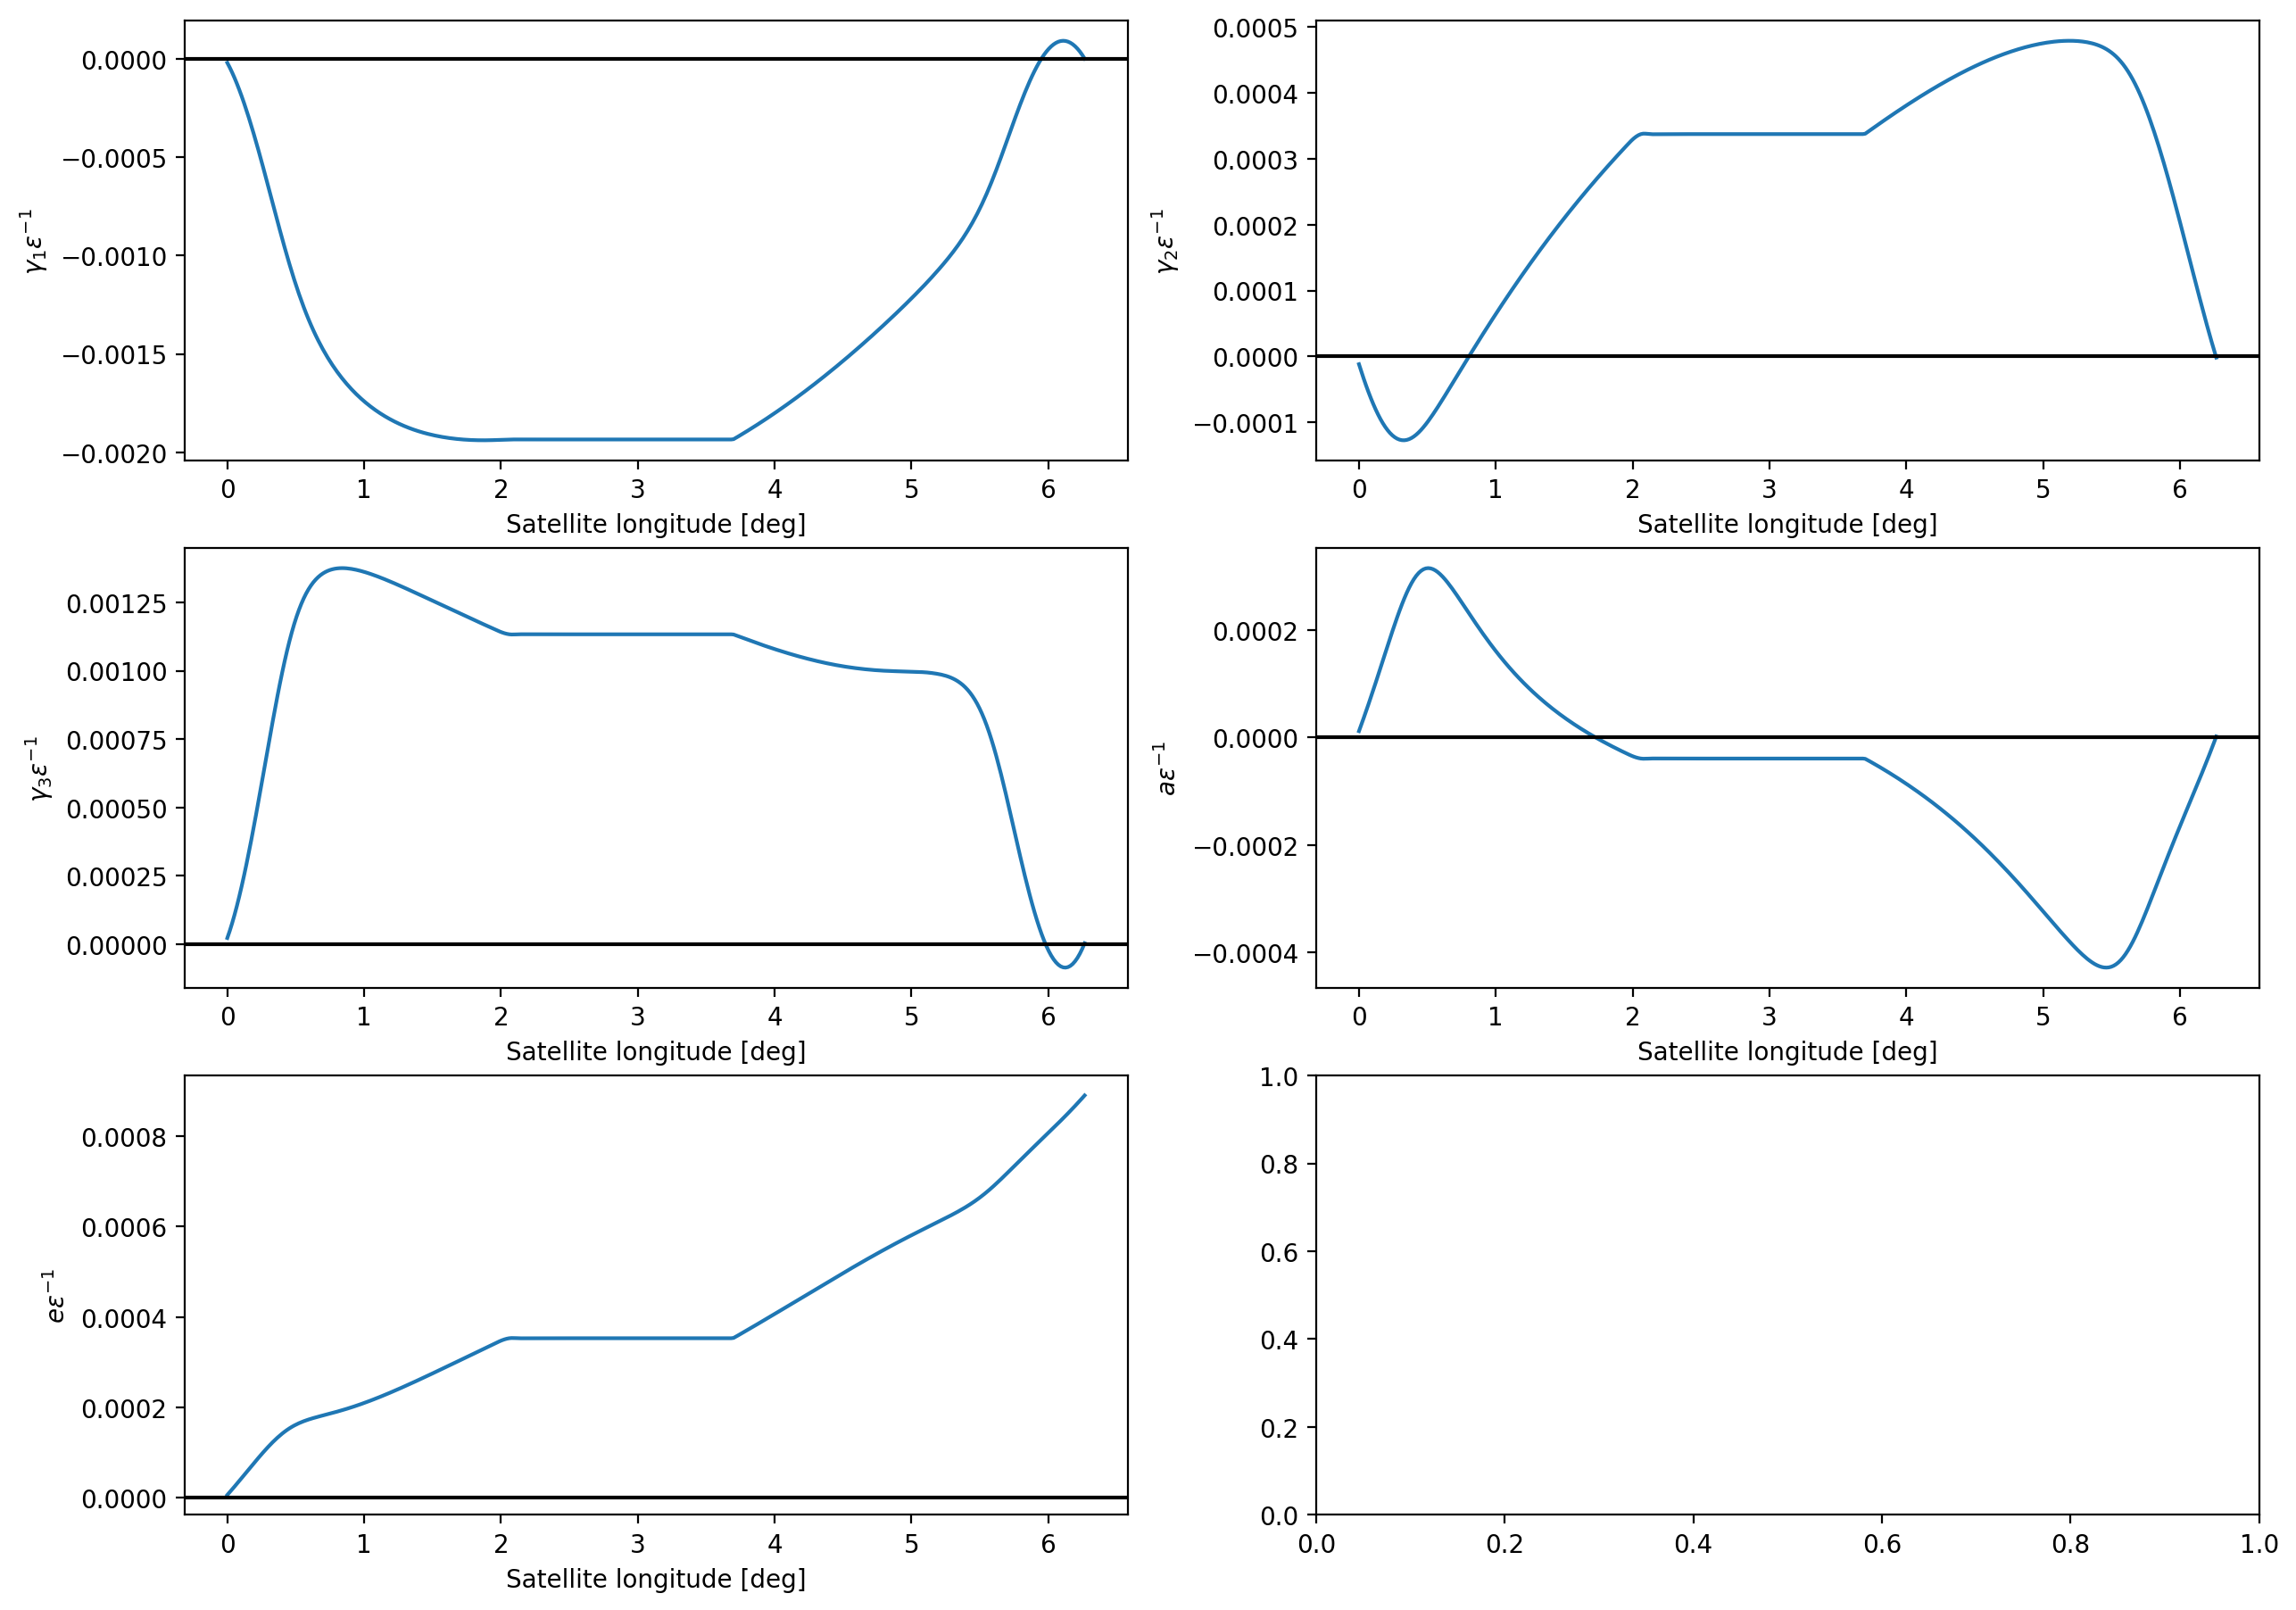

In [13]:
"""
M      = time[:-1]
g1     = out[:,0]-I[0]
g2     = out[:,1]-I[1]
g3     = out[:,2]-I[2]
a      = out[:,3]-I[3]
e      = out[:,4]-I[4]

file2 = open("results/Traj_real_multiple_shoot.txt","w+")
#file2 = open("results/Traj_convex_2.txt","w+")
array_traj = np.transpose(np.array([M,g1,g2,g3,a,e]))
np.savetxt(file2, array_traj , delimiter=",")
file2.close()


fig          = plt.figure(); plt.tight_layout()
ax1          = fig.add_subplot(421) 
ax2          = fig.add_subplot(422) 
ax3          = fig.add_subplot(423) 
ax4          = fig.add_subplot(424) 
ax5          = fig.add_subplot(425) 
ax6          = fig.add_subplot(426) 

ax1.plot(time[:-1], out[:,0]-I[0])
ax2.plot(time[:-1], out[:,1]-I[1])
ax3.plot(time[:-1], out[:,2]-I[2])
ax4.plot(time[:-1], out[:,3]-I[3])
ax5.plot(time[:-1], out[:,4]-I[4])
#ax6.plot(time[:-1], out[:,5])

xlabel       = 'Satellite longitude [deg]'
ax1.set_xlabel(xlabel); ax1.set_ylabel('$\gamma_1 \epsilon^{-1}$'); ax1.axhline(0, color='k')
ax2.set_xlabel(xlabel); ax2.set_ylabel('$\gamma_2 \epsilon^{-1}$'); ax2.axhline(0, color='k')
ax3.set_xlabel(xlabel); ax3.set_ylabel('$\gamma_3 \epsilon^{-1}$'); ax3.axhline(0, color='k')
ax4.set_xlabel(xlabel); ax4.set_ylabel('$a \epsilon^{-1}$');        ax4.axhline(0, color='k')
ax5.set_xlabel(xlabel); ax5.set_ylabel('$e \epsilon^{-1}$');        ax5.axhline(0, color='k')
"""